# Прогнозирование количества заказов такси
## Описание проекта
Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час.
## Цель проекта
Построить модель для такого предсказания количества заказов такси на следующий час.

Значение метрики RMSE на тестовой выборке должно быть не больше 48.

## Загрузка библиотек

In [1]:
! pip install -q catboost

In [2]:
import pandas as pd
import numpy as np

# Визуализация
import matplotlib.pyplot as plt
import seaborn as sns

# ML
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, MinMaxScaler, PowerTransformer
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
pt = PowerTransformer()

from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Ridge
from statsmodels.tsa.statespace import sarimax

# Другое
pd.options.display.expand_frame_repr = False
import warnings
warnings.filterwarnings('ignore')
from time import time
from tqdm import tqdm

# Загрузка файлов с диска
from google.colab import drive
drive.mount('/content/drive')

random = 12345

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Загрузка и изучение данных

In [3]:
# Дата содержится в первой колонке датасета: преобразуем в datetime и делаем её индексной
try:
    df = pd.read_csv('https://code.s3.yandex.net/datasets/taxi.csv', parse_dates=[0], index_col=[0])
except:
    df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/datasets/9_taxi.csv', parse_dates=[0], index_col=[0])

display(df.head(), df.tail())

num_orders
datetime                       
2018-03-01 00:00:00           9
2018-03-01 00:10:00          14
2018-03-01 00:20:00          28
2018-03-01 00:30:00          20
2018-03-01 00:40:00          32

num_orders
datetime                       
2018-08-31 23:10:00          32
2018-08-31 23:20:00          24
2018-08-31 23:30:00          27
2018-08-31 23:40:00          39
2018-08-31 23:50:00          53

In [4]:
# Проверяем индекс на монотонность
df.index.is_monotonic

True

Выполним ресемплирование данных по одному часу. Поскольку предсказываем количество заказов такси на следующий час, аггрегируем суммы значений.

In [5]:
df = df.resample('1H').sum()

In [6]:
print(f"Временной промежуток данных: {df.index.min()} - {df.index.max()}")

Временной промежуток данных: 2018-03-01 00:00:00 - 2018-08-31 23:00:00


## Анализ данных
Разложим данные на три составляющие: тренд, сезонность и остаток. Построим графики последнего месяца временного ряда и проанализируем данные.

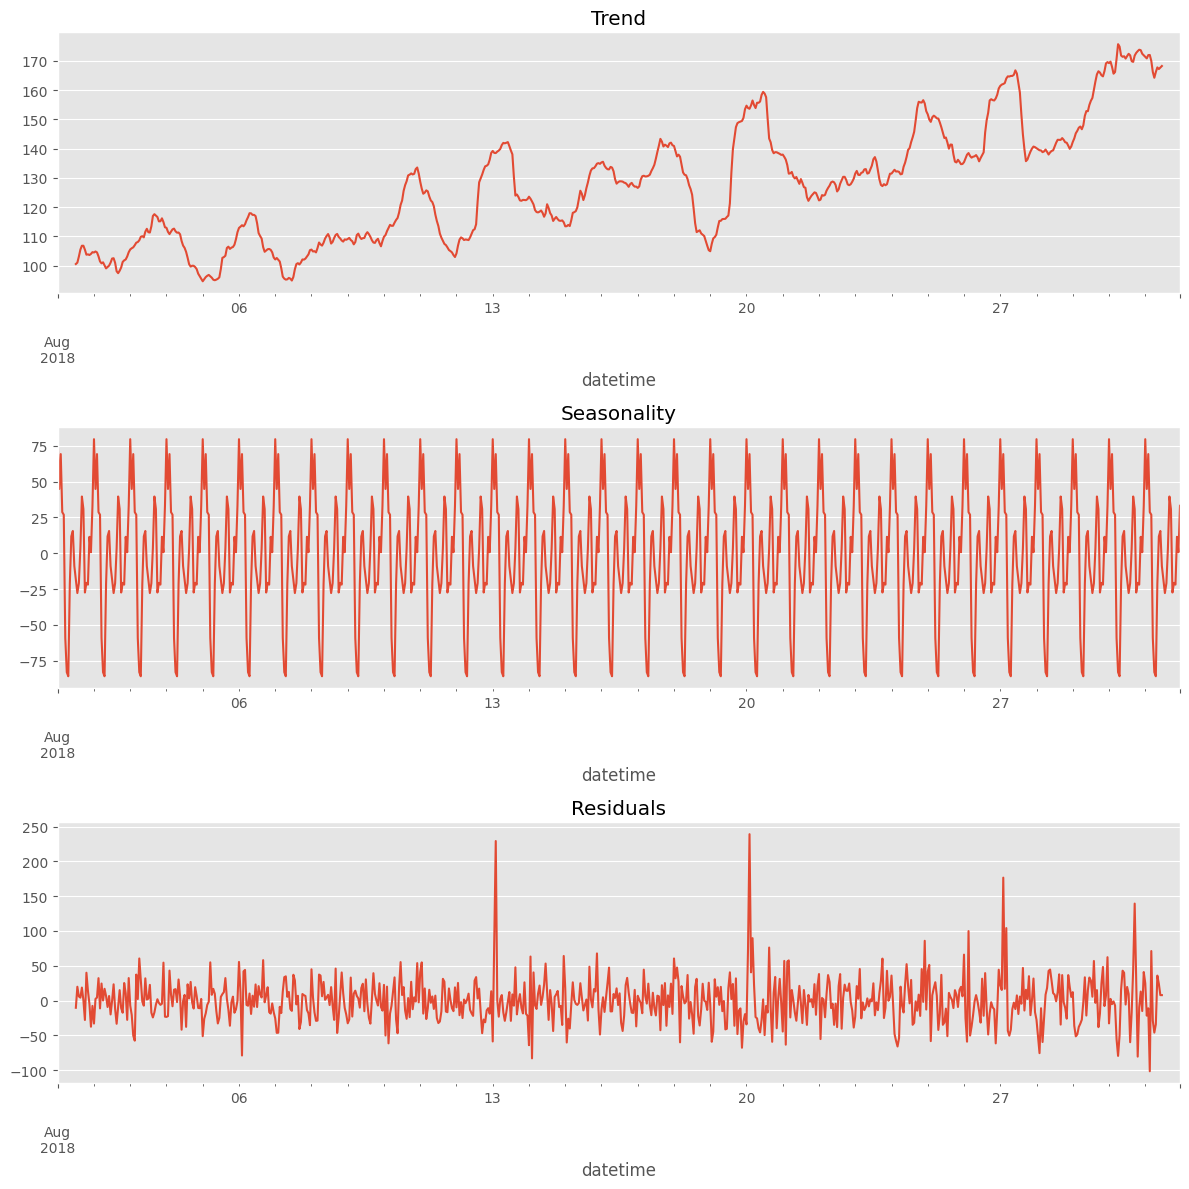

In [7]:
plt.style.use('ggplot')
decomposed = seasonal_decompose(df['2018-08':'2018-08'])
plt.figure(figsize=(12, 12))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

> - Распределение сезонной части выглядит статическим в интервале суток. Ночью такси почти не заказывают, пик ближе к вечеру.
>
> - Случайная часть также имеет постоянной среднее значение, но периодически возникают большие всплески (объясняются повышенным спросом на такси по выходным и праздникам).
>
> - Трэнд показывает линейный рост количества заказов со временем.

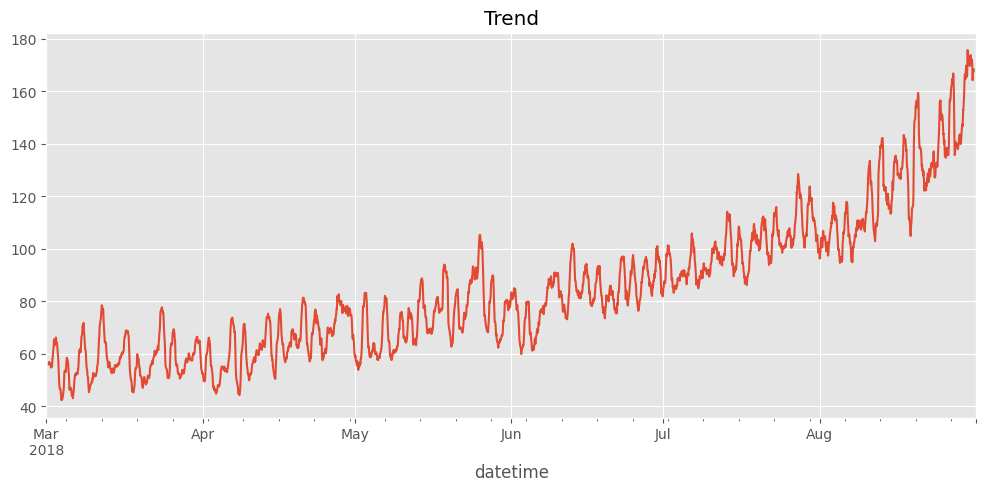

In [8]:
# Построим тренд для всего временного ряда, чтобы увидеть полную картину
plt.style.use('ggplot')
decomposed = seasonal_decompose(df)
plt.figure(figsize=(12, 5))
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend');

> - Исходя из тренда, количество заказов постепенно увеличивается. Неизвестно, как это связано, возможно, в летнее время люди чаще на улице или цена заказов упала и люди стали чаще брать такси. Но данные всего за полгода, потому не до конца верно анализировать такой короткий срок. Трэнд имеет более сложную зависимость от времени (квадраичная или экспоненциальная, сложно оценить по днной выборке). Для нашей задачи будем считать его линейным (предсказания нам нужны всего на час вперёд).
>
> - Также заметим, что линия тренда имеет некоторый шум. Исходя из шума - заказов к концу лета куда выше, от чего график разнится. Возможно, для предсказания будет необходимо применить скользящее среднее с окном в несколько десятков часов.

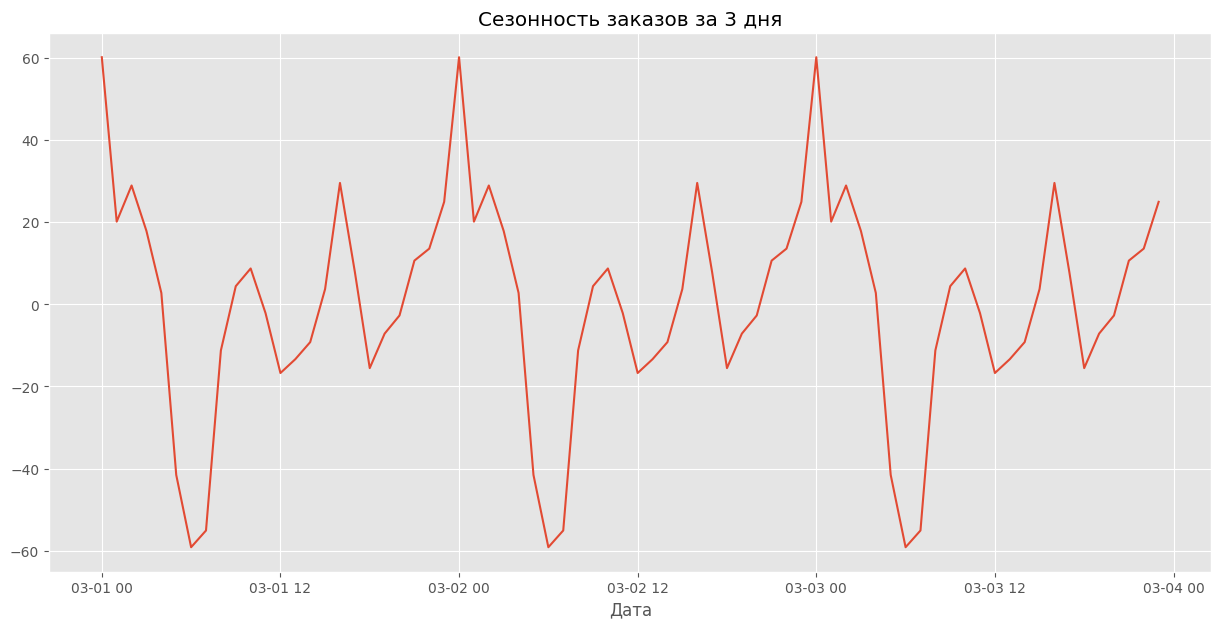

In [9]:
# Построим график только за несколько дней, чтобы рассмотреть лучше
plt.figure(figsize=(15,7))
plt.plot(decomposed.seasonal['2018-03-01':'2018-03-3'])
plt.title('Сезонность заказов за 3 дня')
plt.xlabel('Дата')
plt.show()

> Чётко прослеживается сезонность, скорее всего привязанная к активности людей в течение суток: минимум заказов в 6 утра и постепенно увеличивается в конце дня.

###  Стационарный ряд

In [10]:
test = adfuller(df)
print('adf: ', test[0])
print('p-value: ', test[1])
print('Critical values: ', test[4])
if test[0] > test[4]['5%']:
    print('есть единичные корни, ряд не стационарен')
else:
    print('единичных корней нет, ряд стационарен')

adf:  -3.0689242890279504
p-value:  0.028940051402613316
Critical values:  {'1%': -3.431842162413052, '5%': -2.8621993540813637, '10%': -2.567120978470452}
единичных корней нет, ряд стационарен


> По результатам расширенного теста Дики-Фулера временной ряд можно с натяжкой признать стационарным (критическое значение для 1% уровня значимости -3.43 меньше результата теста -3.06). Возможно, нужно дифферинцировать ряд.

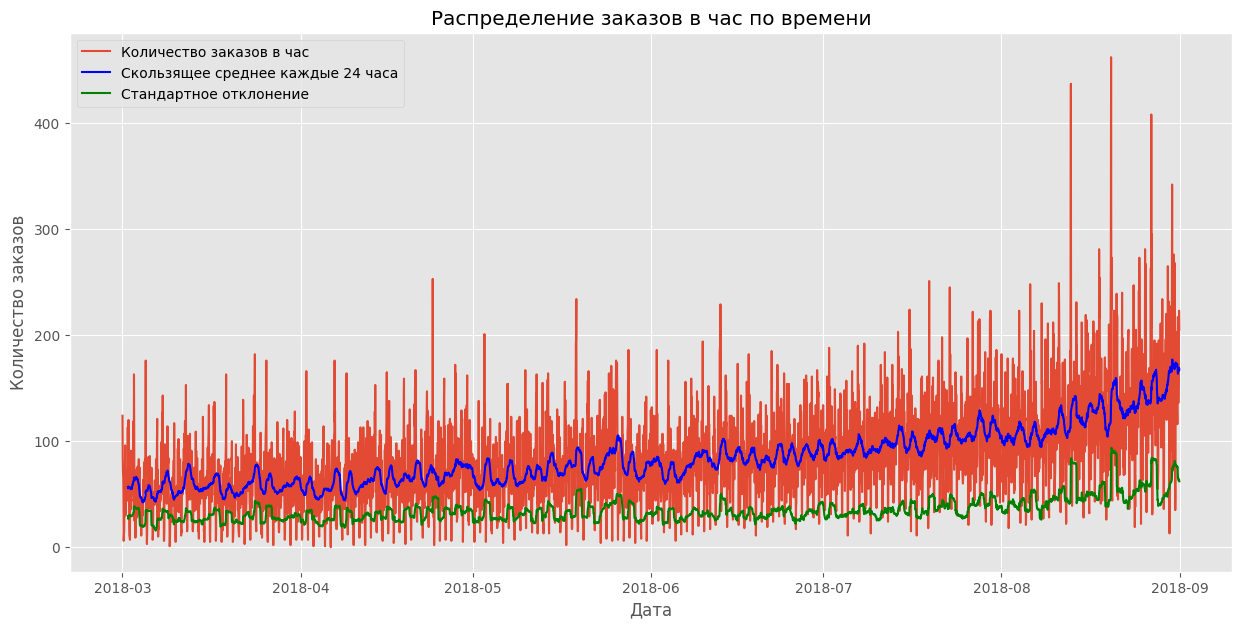

In [11]:
# Найдём скользящее стандартное отклонение — стандартное отклонение по скользящему окну:
plt.figure(figsize=(15, 7))
plt.plot(df)
plt.plot(df.rolling(24).mean(), color='blue')
plt.plot(df.rolling(24).std(), color='green')
plt.title('Распределение заказов в час по времени')
plt.legend(['Количество заказов в час', 'Скользящее среднее каждые 24 часа', 'Стандартное отклонение'])
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.show();

### Разность временного ряда
Чтобы ряд сделать стационарным, найдём разности его значений.

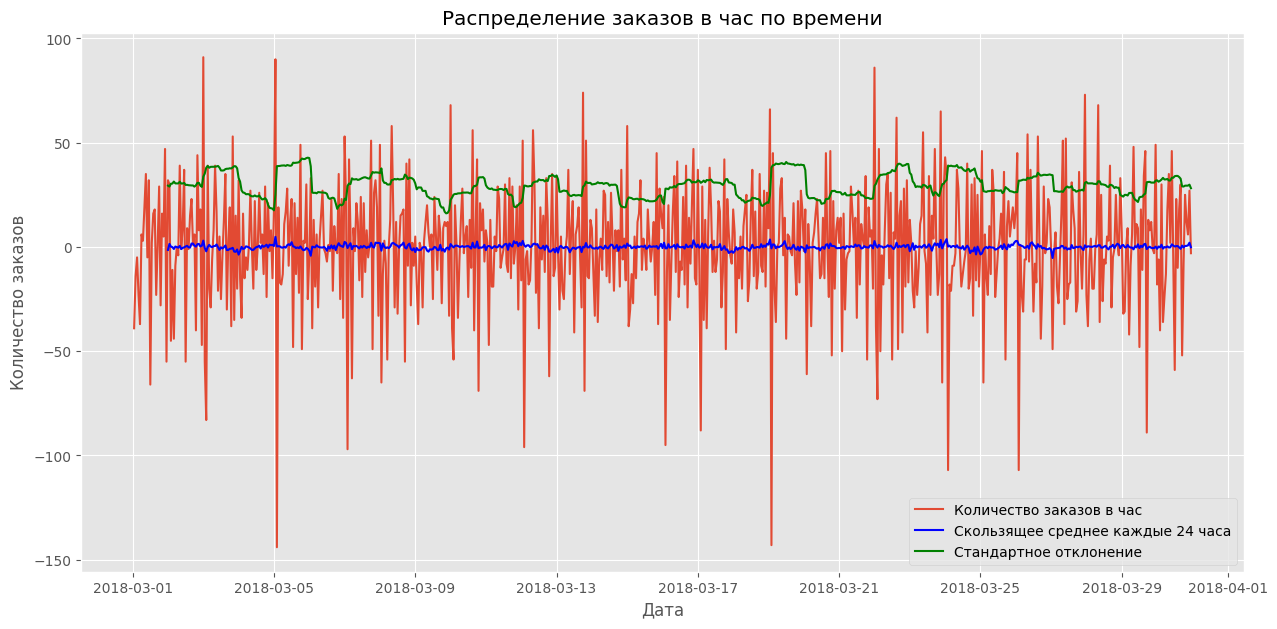

In [12]:
shifted_df = df - df.shift()

plt.figure(figsize=(15, 7))
plt.plot(shifted_df['2018-03-01':'2018-03-30'])
plt.plot(shifted_df['2018-03-01':'2018-03-30'].rolling(24).mean(), color='blue')
plt.plot(shifted_df['2018-03-01':'2018-03-30'].rolling(24).std(), color='green')
plt.title('Распределение заказов в час по времени')
plt.legend(['Количество заказов в час', 'Скользящее среднее каждые 24 часа', 'Стандартное отклонение'])
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.show();

> Как видно из полученного графика, ряд стал стационарным, то есть, если не удастся получить необходимые метрики качества, можно воспользоваться разностью временного ряда.

## Подготовка данных

Напишем функцию для создания признаков. Разберём каждый тип признаков:

1. Календарные признаки - во многих данных тренды и сезонность привязаны к конкретной дате. Тип datetime64 в Pandas уже содержит нужную информацию, осталось лишь представить её как отдельные столбцы.
2. Отстающие значения - предыдущие значения временного ряда подскажут, будет ли функция x(t) расти или уменьшаться.
3. Скользящее среднее - скользящее среднее как признак задаёт общий тренд временного ряда.

**Так как у нас идет увеличение числа заказов в течении дня - возьмём максимальное отстающее значение - 24 часа, а скользящее среднее по 6 часов, так как наблюдается, что каждые 6 часов количество заказов как растет, так и падает.**

In [13]:
def make_features(data, max_lag, rolling_mean_size):
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour

    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

In [14]:
df_copy = df.copy()

# Создадим новые признаки
make_features(df_copy, 1, 24)

In [15]:
df_copy.head()

num_orders  dayofweek  hour  lag_1  rolling_mean
datetime                                                             
2018-03-01 00:00:00         124          3     0    NaN           NaN
2018-03-01 01:00:00          85          3     1  124.0           NaN
2018-03-01 02:00:00          71          3     2   85.0           NaN
2018-03-01 03:00:00          66          3     3   71.0           NaN
2018-03-01 04:00:00          43          3     4   66.0           NaN

In [16]:
# Разделим выборки и проверим их порядочность
train, test = train_test_split(df_copy, shuffle=False, test_size=0.1, random_state=random)
train = train.dropna()

print(train.index.min(), train.index.max())
print(test.index.min(), test.index.max())

X_train = train.drop('num_orders', axis=1)
y_train = train['num_orders']
X_test = test.drop('num_orders', axis=1)
y_test = test['num_orders']

2018-03-02 00:00:00 2018-08-13 13:00:00
2018-08-13 14:00:00 2018-08-31 23:00:00


## Обучение моделей

In [17]:
# Создадим таблицу для сравнения моделей
analisys = pd.DataFrame({'model':[], 'RMSE_model':[], 'RMSE_on_train':[]})
all_models = []

In [18]:
# Создадим функцию для подбора параметров
def train_model(model, parameters):

    best_rmse = 1000
    best_model = 0

    start = time()

    tscv = TimeSeriesSplit(n_splits=cv_splits, max_train_size=cv_train_test_split)

    model_random = GridSearchCV(estimator=model,
                                param_grid=parameters,
                                scoring='neg_mean_absolute_error',
                                n_jobs=-1,
                                cv=tscv,
                                verbose=1,
                                error_score='raise')
    model_random.fit(X_train, y_train)
    rmse = model_random.best_score_ * -1 ** 0.5
    if rmse < best_rmse:
        best_rmse = rmse
        best_model = model_random
    print('GridSearchCV подбирал параметры %.2f секунд' %(time() - start))

    model_random = best_model

    # Высчитаем метрики
    rmse = model_random.best_score_ * -1 ** 0.5
    rmse_on_train = mean_squared_error(y_train, model_random.predict(X_train), squared=False)

    print('Лучшие параметры:', model_random.best_params_)
    print('RMSE обученной модели:', rmse)
    print('RMSE на тренировочной выборке:', rmse_on_train)

    predicted = pd.DataFrame(model_random.predict(X_train), index=X_train.index)
    plt.figure(figsize=(15,7))
    plt.plot(y_train[:'2018-03-07'], color='black', alpha=0.7)
    plt.plot(predicted[:'2018-03-07'], color='red', alpha=0.7)
    plt.title('Сравнение предсказаний на трейне модели за первые 7 дней')
    plt.ylabel('Количество заказов')
    plt.xlabel('Дата')
    plt.legend(['Реальные', 'Предсказанные'])
    plt.show()

    # Заполним все таблицы
    all_models.append(model_random)
    row = []
    row.extend([model, rmse, rmse_on_train])
    analisys.loc[len(analisys.index)] = row

    return model_random

In [19]:
cv_splits = 3
cv_train_test_split = (train.shape[0] * 4 // 5)

### DecisionTreeRegressor

Fitting 3 folds for each of 9 candidates, totalling 27 fits
GridSearchCV подбирал параметры 11.84 секунд
Лучшие параметры: {'max_depth': 7}
RMSE обученной модели: 23.114010920374252
RMSE на тренировочной выборке: 22.66158711034978


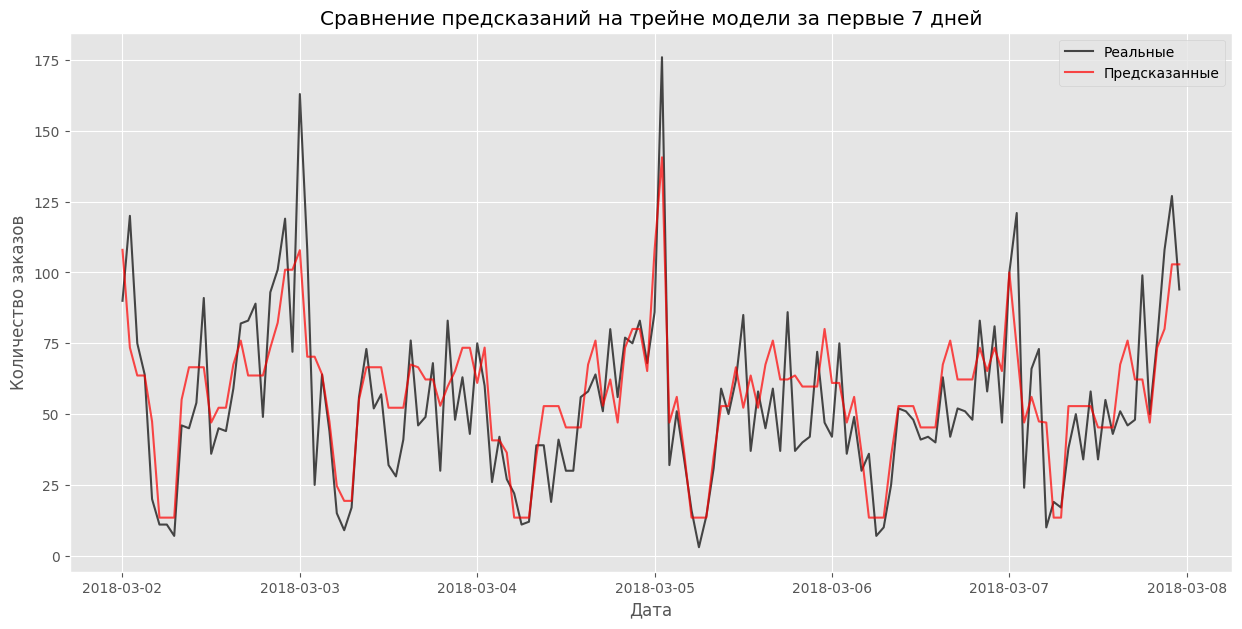

In [20]:
# Зададим рандомные параметры
ran_grid_tree = {"max_depth": list(range(3, 12))}

# Инициализируем модель
dtr_model = DecisionTreeRegressor()

# Обучим и сохраним значения
dtr_random = train_model(dtr_model, ran_grid_tree)

### RandomForestRegressor

Fitting 3 folds for each of 28 candidates, totalling 84 fits
GridSearchCV подбирал параметры 70.62 секунд
Лучшие параметры: {'max_depth': 8, 'n_estimators': 200}
RMSE обученной модели: 20.805911576013028
RMSE на тренировочной выборке: 19.601920396287884


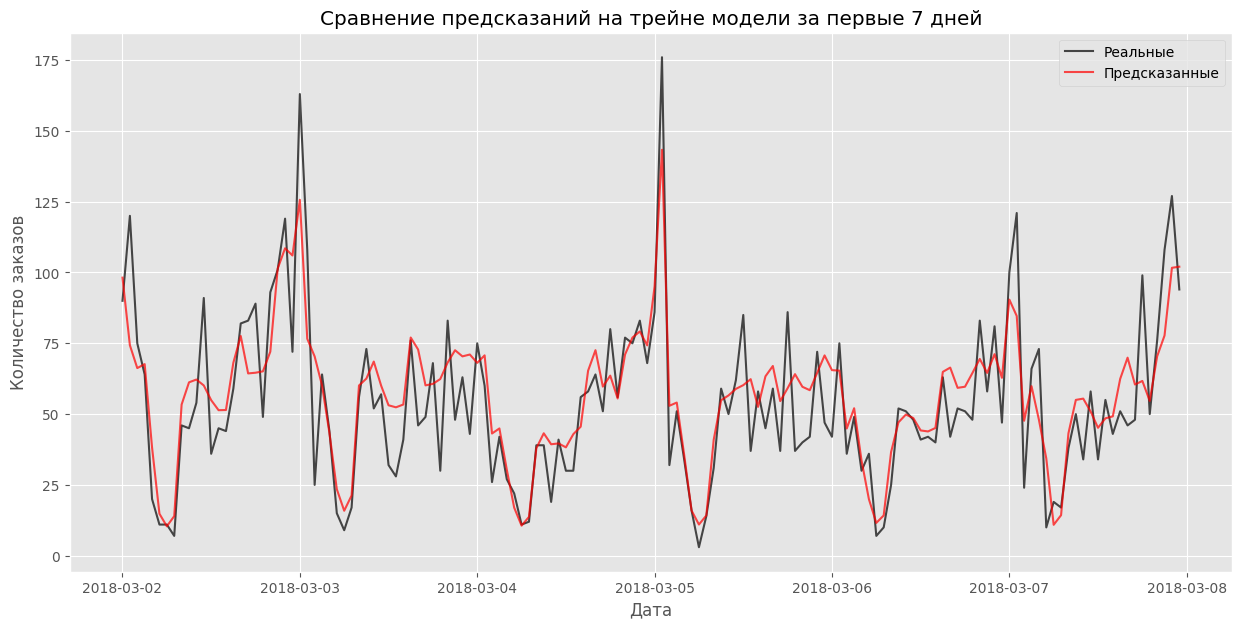

In [21]:
# Зададим рандомные параметры
ran_grid_forest = {'max_depth': list(range(2, 9)),
                   'n_estimators': [50, 100, 200, 300]
                  }

# Инициализируем модель
rfr_model = RandomForestRegressor(n_jobs=-1, random_state=random)

# Обучим и сохраним значения
rfr_random = train_model(rfr_model, ran_grid_forest)

### Ridge

Fitting 3 folds for each of 4 candidates, totalling 12 fits
GridSearchCV подбирал параметры 0.09 секунд
Лучшие параметры: {'alpha': 1.0}
RMSE обученной модели: 25.04857629173013
RMSE на тренировочной выборке: 30.907085355412203


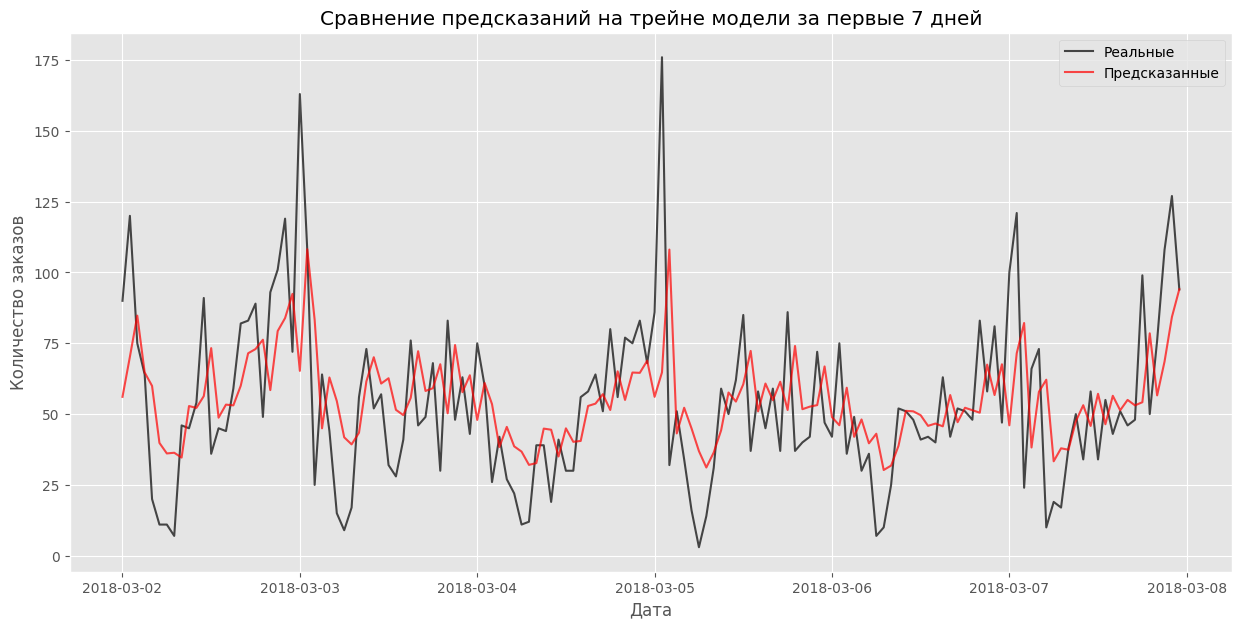

In [22]:
# Зададим рандомные параметры
ran_grid_ridge = {'alpha': np.logspace(0,3,4)}

# Инициализируем модель
ridge_model = Ridge(random_state=random)

# Обучим и сохраним значения
ridge_random = train_model(ridge_model, ran_grid_ridge)

### CatBoostRegressor

Fitting 3 folds for each of 25 candidates, totalling 75 fits
GridSearchCV подбирал параметры 50.06 секунд
Лучшие параметры: {'learning_rate': 0.1, 'max_depth': 2}
RMSE обученной модели: 20.55099493804488
RMSE на тренировочной выборке: 20.338667152211986


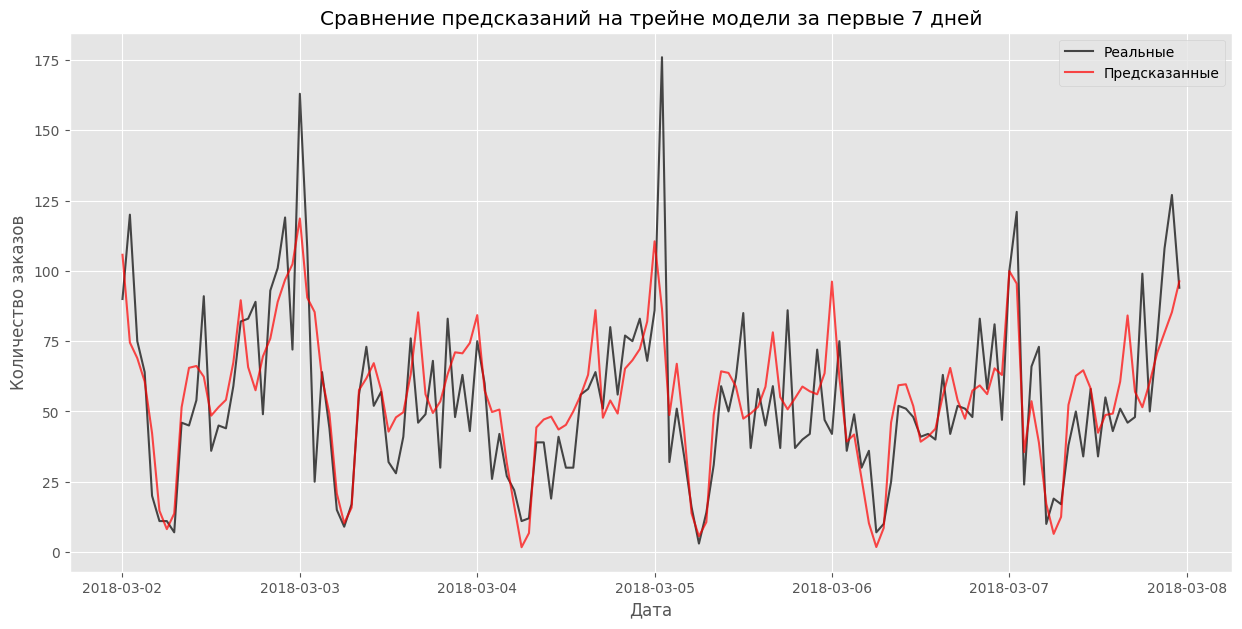

In [23]:
# Зададим рандомные параметры
rand_cat_param = {'max_depth': [1, 2, 3, 4, 5],
                  'learning_rate': [x/10 for x in range(1, 6)]
                 }

# Инициализируем модель
cat_model = CatBoostRegressor(loss_function='RMSE', verbose=False, random_seed = random)

# Обучим и сохраним значения
cat_random = train_model(cat_model, rand_cat_param)

###  Сравнение моделей

In [24]:
all_names = pd.DataFrame({'names':['DecisionTree', 'RandomForest', 'Ridge', 'CatBoost']})
analisys = pd.concat([analisys, all_names], axis=1, join='inner')
display(analisys)

model  RMSE_model  RMSE_on_train         names
0                            DecisionTreeRegressor()   23.114011      22.661587  DecisionTree
1  RandomForestRegressor(n_jobs=-1, random_state=...   20.805912      19.601920  RandomForest
2                          Ridge(random_state=12345)   25.048576      30.907085         Ridge
3  <catboost.core.CatBoostRegressor object at 0x7...   20.550995      20.338667      CatBoost

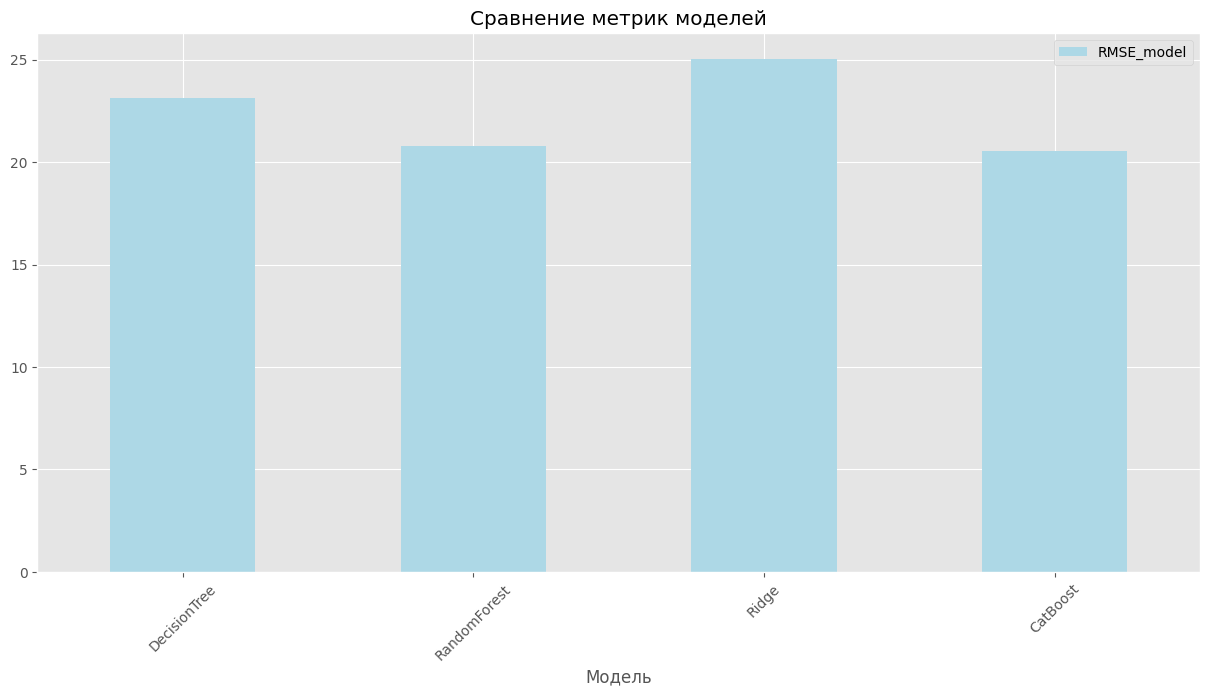

In [25]:
analisys.plot.bar(y='RMSE_model', x='names', rot=45, figsize=(15,7), color='lightblue')
plt.title('Сравнение метрик моделей', fontsize='x-large')
plt.xlabel('Модель')
plt.show()

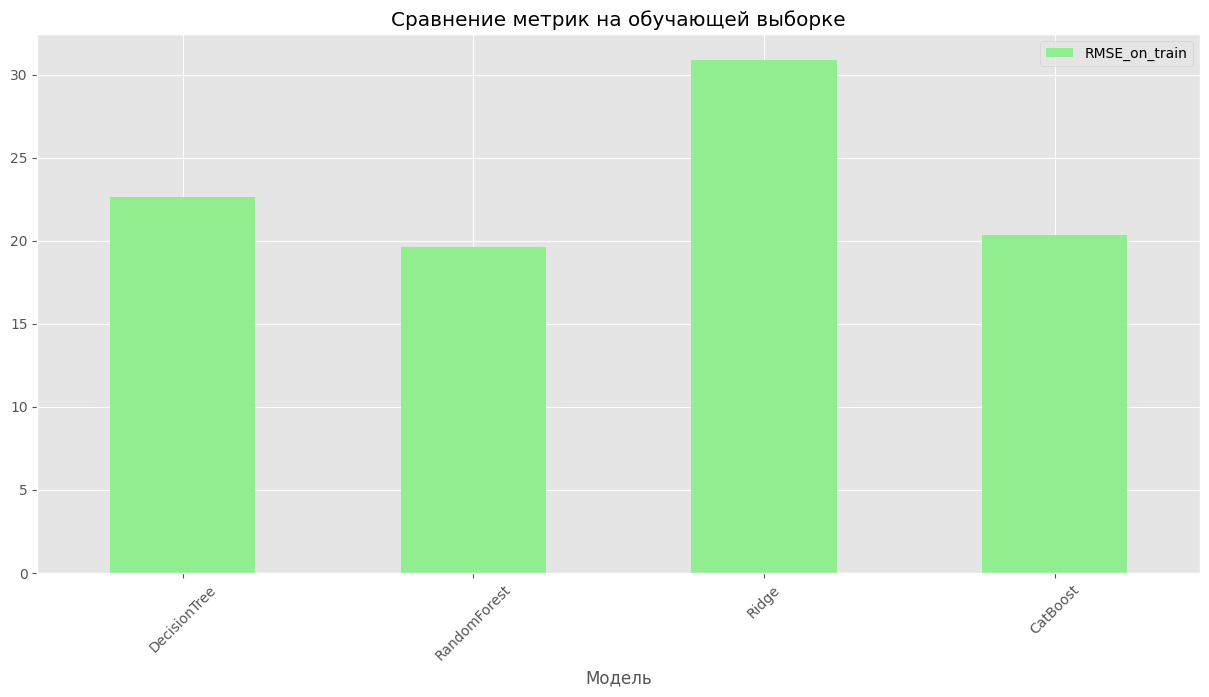

In [26]:
analisys.plot.bar(y='RMSE_on_train', x='names', rot=45, figsize=(15,7), color='lightgreen')
plt.title('Сравнение метрик на обучающей выборке', fontsize='x-large')
plt.xlabel('Модель')
plt.show()

> Исходя из полученных моделей, лучше всего себя показала на рандомной модели - CatBoostRegressor с параметрами 'learning_rate': 0.1, 'max_depth': 3, потому её и будем использовать для тестовой выборки.

## Тестирование

In [27]:
# Данные изначально подготовлены,
# потому рассмотрим метрики ранее обученной модели на тестовой выборке
predicted = cat_random.predict(X_test)
rmse_on_test = mean_squared_error(y_test, predicted, squared=False)
print('RMSE на тестовой выборке:', rmse_on_test)

RMSE на тестовой выборке: 50.38007434270961


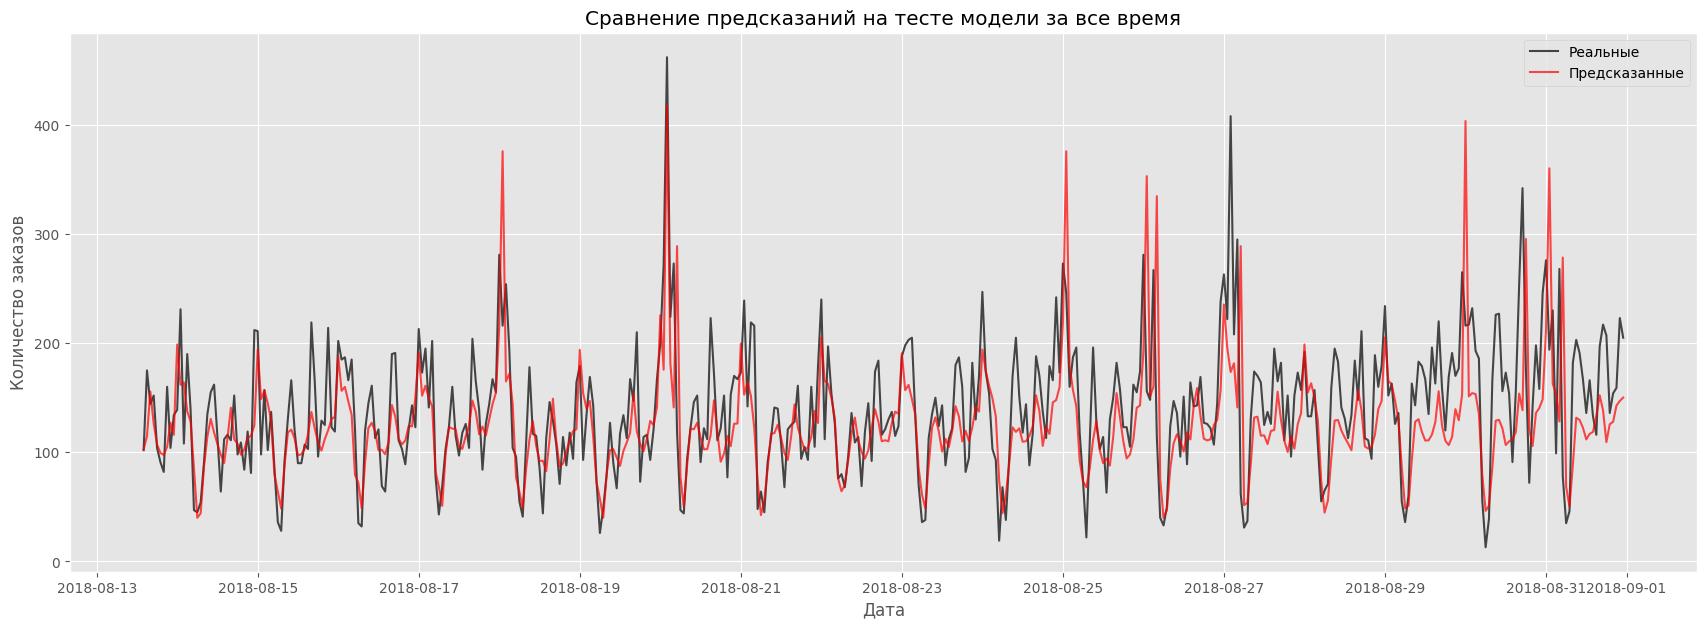

In [28]:
# Рассмотрим графики сравнения предсказаний и реальных значений
predicted = pd.DataFrame(predicted, index=X_test.index)

plt.figure(figsize=(21,7))
plt.plot(y_test, color='black', alpha=0.7)
plt.plot(predicted, color='red', alpha=0.7)
plt.title('Сравнение предсказаний на тесте модели за все время')
plt.ylabel('Количество заказов')
plt.xlabel('Дата')
plt.legend(['Реальные', 'Предсказанные'])
plt.show()

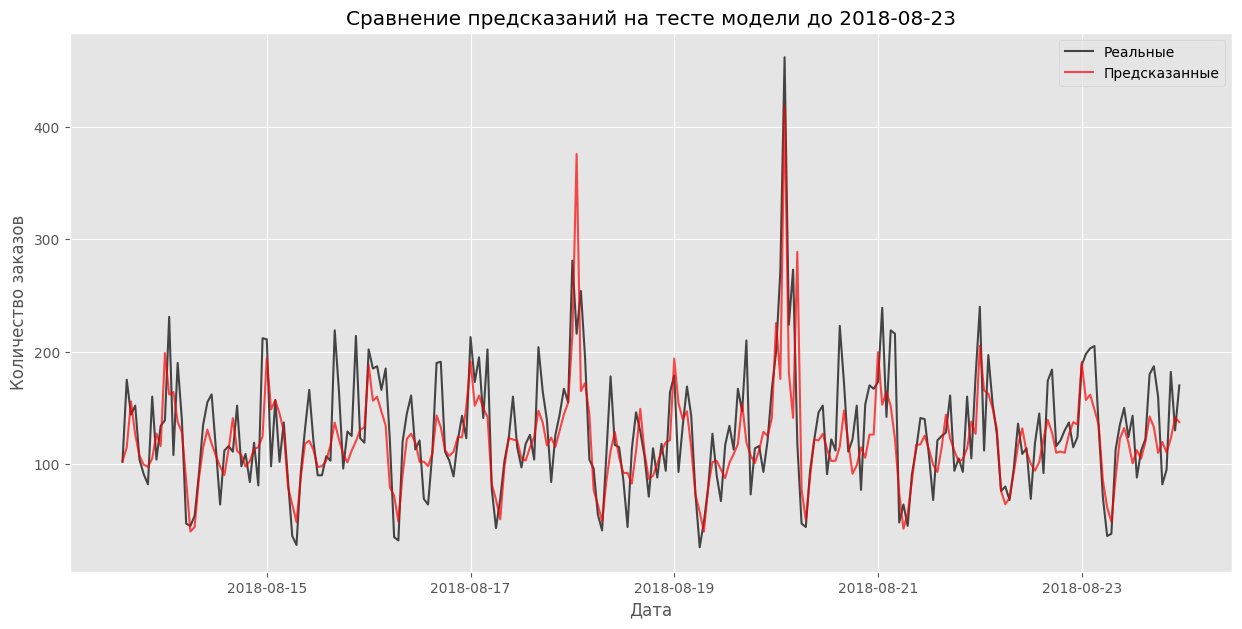

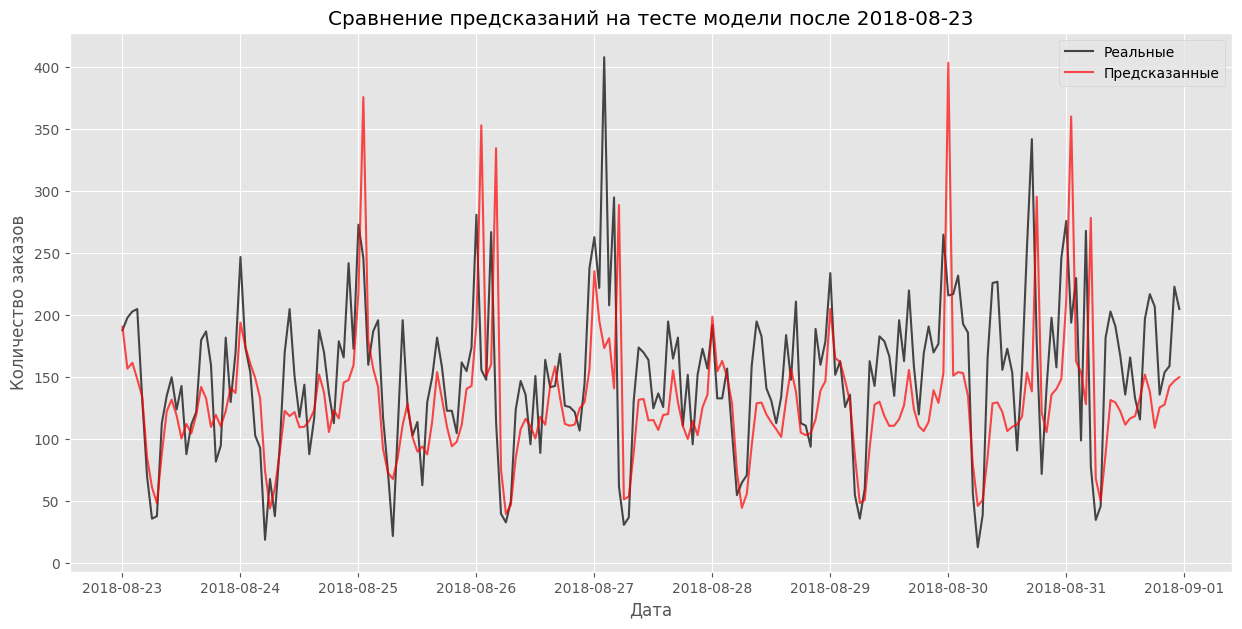

In [29]:
plt.figure(figsize=(15,7))
plt.plot(y_test[:'2018-08-23'], color='black', alpha=0.7)
plt.plot(predicted[:'2018-08-23'], color='red', alpha=0.7)
plt.title('Сравнение предсказаний на тесте модели до 2018-08-23')
plt.ylabel('Количество заказов')
plt.xlabel('Дата')
plt.legend(['Реальные', 'Предсказанные'])
plt.show()

plt.figure(figsize=(15,7))
plt.plot(y_test['2018-08-23':], color='black', alpha=0.7)
plt.plot(predicted['2018-08-23':], color='red', alpha=0.7)
plt.title('Сравнение предсказаний на тесте модели после 2018-08-23')
plt.ylabel('Количество заказов')
plt.xlabel('Дата')
plt.legend(['Реальные', 'Предсказанные'])
plt.show()

## Вывод:
RMSE модели CatBoostRegressor 50.4 и по графикам видно, что модель ошибается сильнее, где тренд увеличения заказов стал выше.

Данных слишком мало, чтобы точно предсказывать, что тренд заказов увеличится. И так же плохо предсказывает резкие выбросы значений - где заказов было значительно больше.

По техническому заданию RMSE не должно быть выше 48, наша модель не проходит, поэтому попробуем аналитескую модель SARIMA.

## Аналитическая модель SARIMA
Так как наш ряд нестационарен из-за причины тренда и обладает сезонностью в течении дня то для предсказания будующих значений нам подойдет алгоритм SARIMA.

Общий вид данной модели: $$ARIMA(p,d,q)(P,D,Q)_s$$
В этой модели параметры обозначают следующее:
- p — порядок модели **AR(p)**
- d — порядок интегрирования исходных данных
- q — порядок модели **MA(q)**
- P — порядок сезонной составляющей **SAR(P)**
- D — порядок интегрирования сезонной составляющей
- Q — порядок сезонной составляющей **SMA(Q)**
- s — размерность сезонности(месяц, квартал и т.д.)

Поскольку наш временной ряд ресемплирован по часам, то сезонностью для него будет день или 24 часа.

In [30]:
# Проведём сезонное дифференцирование
data = df.copy()
data_D1 = data - data.shift(24)
data_D1.dropna(inplace=True)

In [31]:
# Проверим стационарность после применения первого дифференцирования
test = sm.tsa.adfuller(data_D1['num_orders'])
print('adf: ', test[0])
print('p-value: ', test[1])
print('Critical values: ', test[4])
if test[0]> test[4]['5%']:
    print('есть единичные корни, ряд не стационарен')
else:
    print('единичных корней нет, ряд стационарен')

adf:  -16.00615394827062
p-value:  6.430826940726963e-29
Critical values:  {'1%': -3.4318507234354523, '5%': -2.8622031360567024, '10%': -2.567122991804141}
единичных корней нет, ряд стационарен


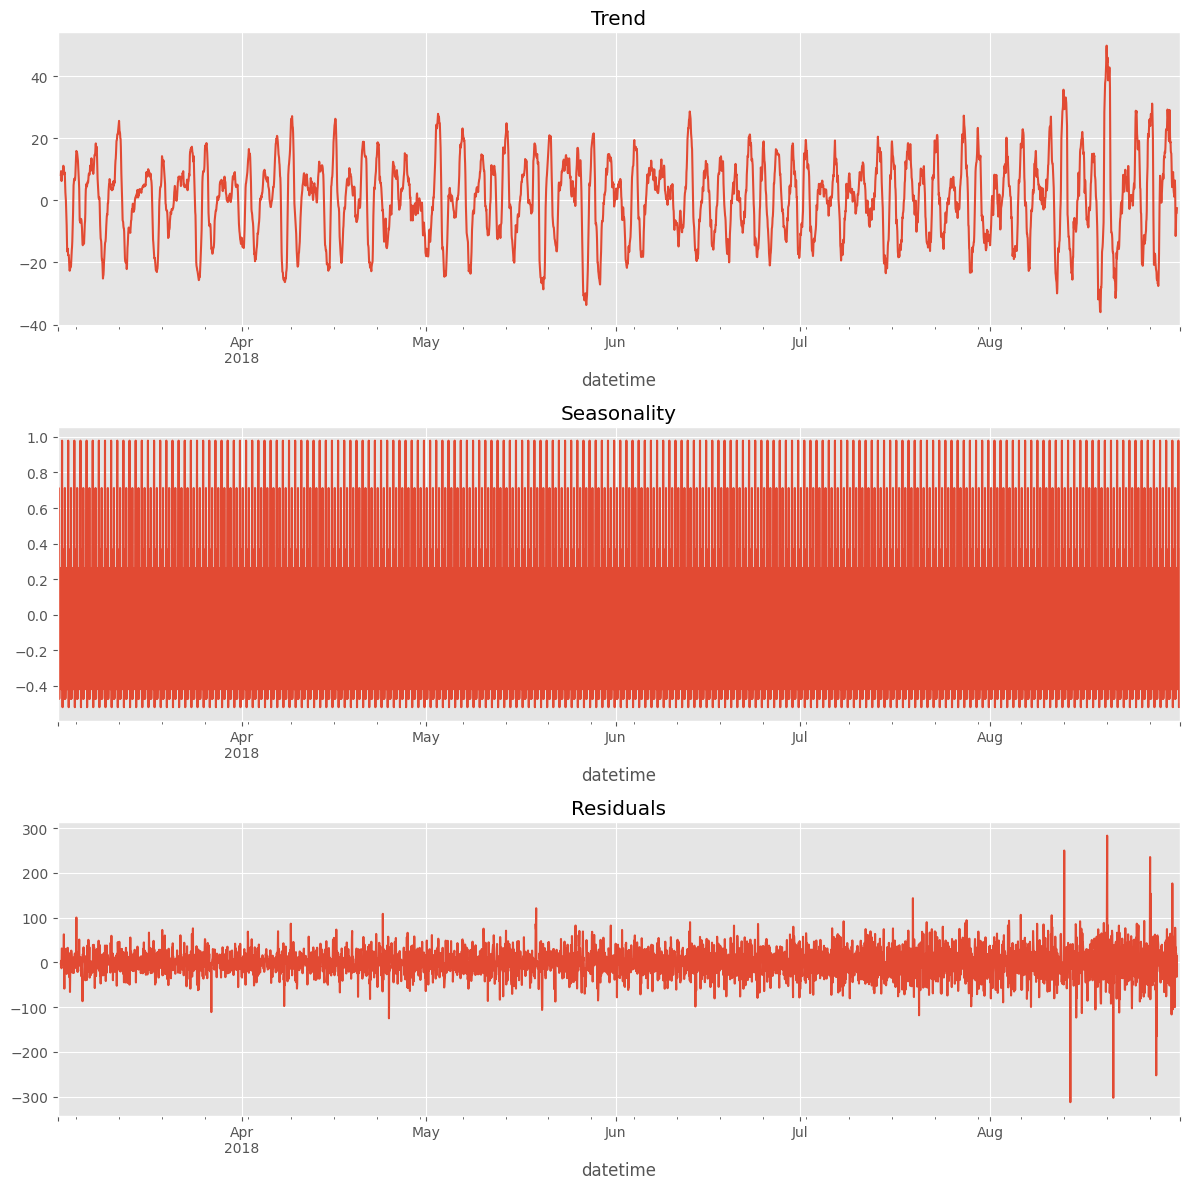

In [32]:
plt.style.use('ggplot')
decomposed_data_D1 = seasonal_decompose(data_D1)
plt.figure(figsize=(12, 12))

plt.subplot(311)
decomposed_data_D1.trend.plot(ax=plt.gca())
plt.title('Trend')

plt.subplot(312)
decomposed_data_D1.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')

plt.subplot(313)
decomposed_data_D1.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

> Если изучить тренд, то видно, что он напоминает стационарный ряд, но сильно колеблится. Проверим дифференцирование на предыдущем дне.

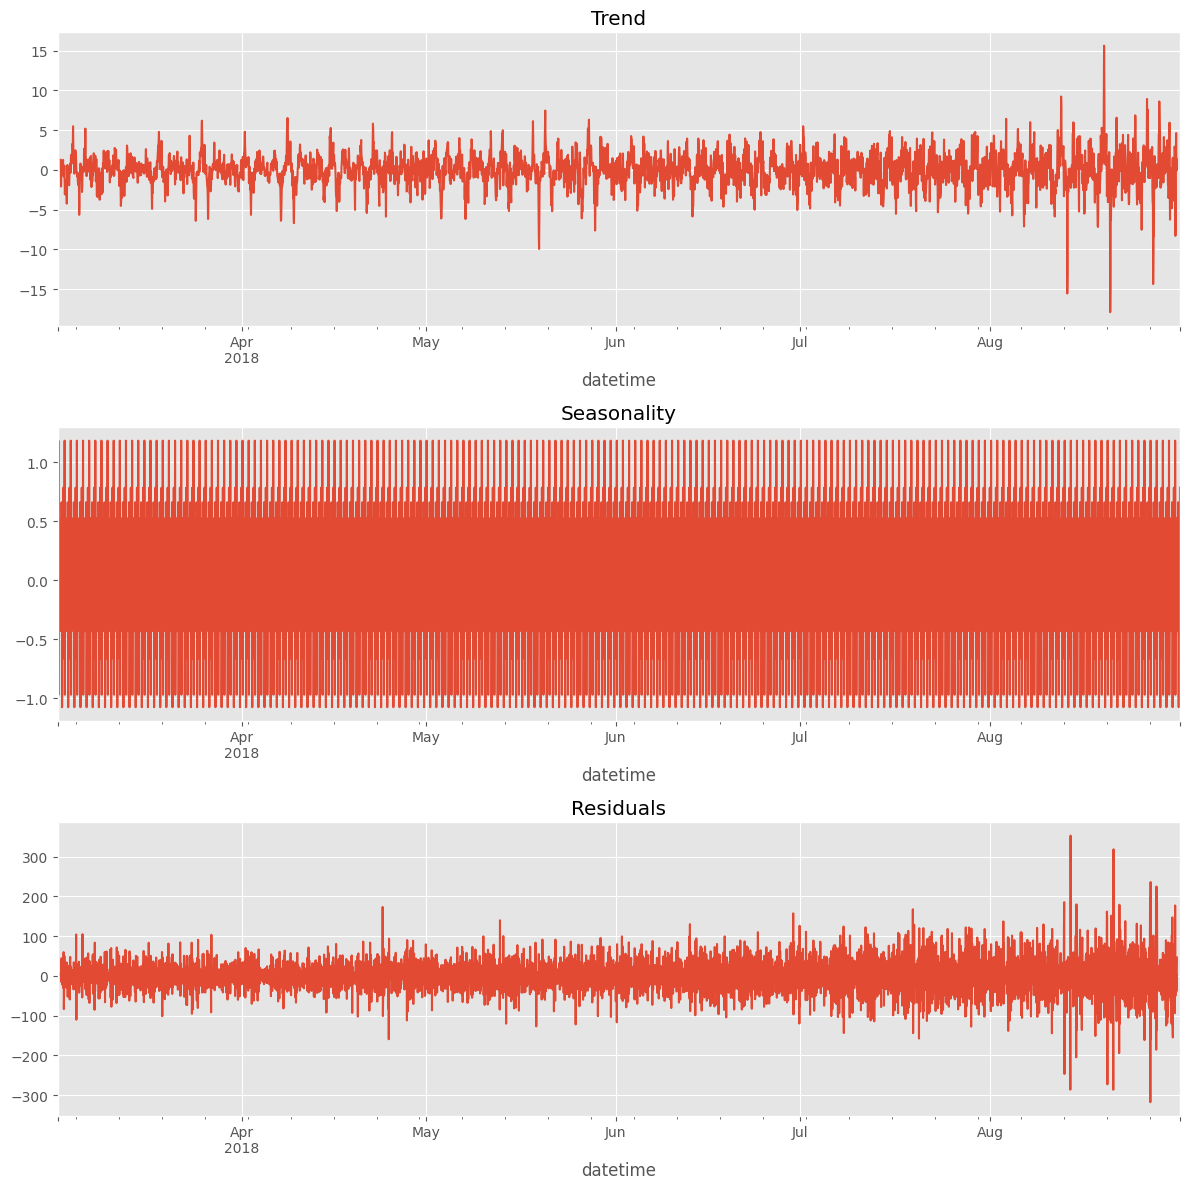

In [33]:
data_D1_d1 = data_D1 - data_D1.shift(1)
data_D1_d1.dropna(inplace=True)

plt.style.use('ggplot')
decomposed_data_D1_d1 = seasonal_decompose(data_D1_d1['num_orders'])
plt.figure(figsize=(12, 12))

plt.subplot(311)
decomposed_data_D1_d1.trend.plot(ax=plt.gca())
plt.title('Trend')

plt.subplot(312)
decomposed_data_D1_d1.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')

plt.subplot(313)
decomposed_data_D1_d1.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

In [34]:
# Проверим стационарность после применения дифференцирования на предыдущем дне
test = sm.tsa.adfuller(data_D1_d1)
print('adf: ', test[0])
print('p-value: ', test[1])
print('Critical values: ', test[4])
if test[0]> test[4]['5%']:
    print('есть единичные корни, ряд не стационарен')
else:
    print('единичных корней нет, ряд стационарен')

adf:  -23.20802006961447
p-value:  0.0
Critical values:  {'1%': -3.4318510679201006, '5%': -2.8622032882383506, '10%': -2.5671230728180445}
единичных корней нет, ряд стационарен


> Разброс тренда изменился. Повторим дифференцирование.

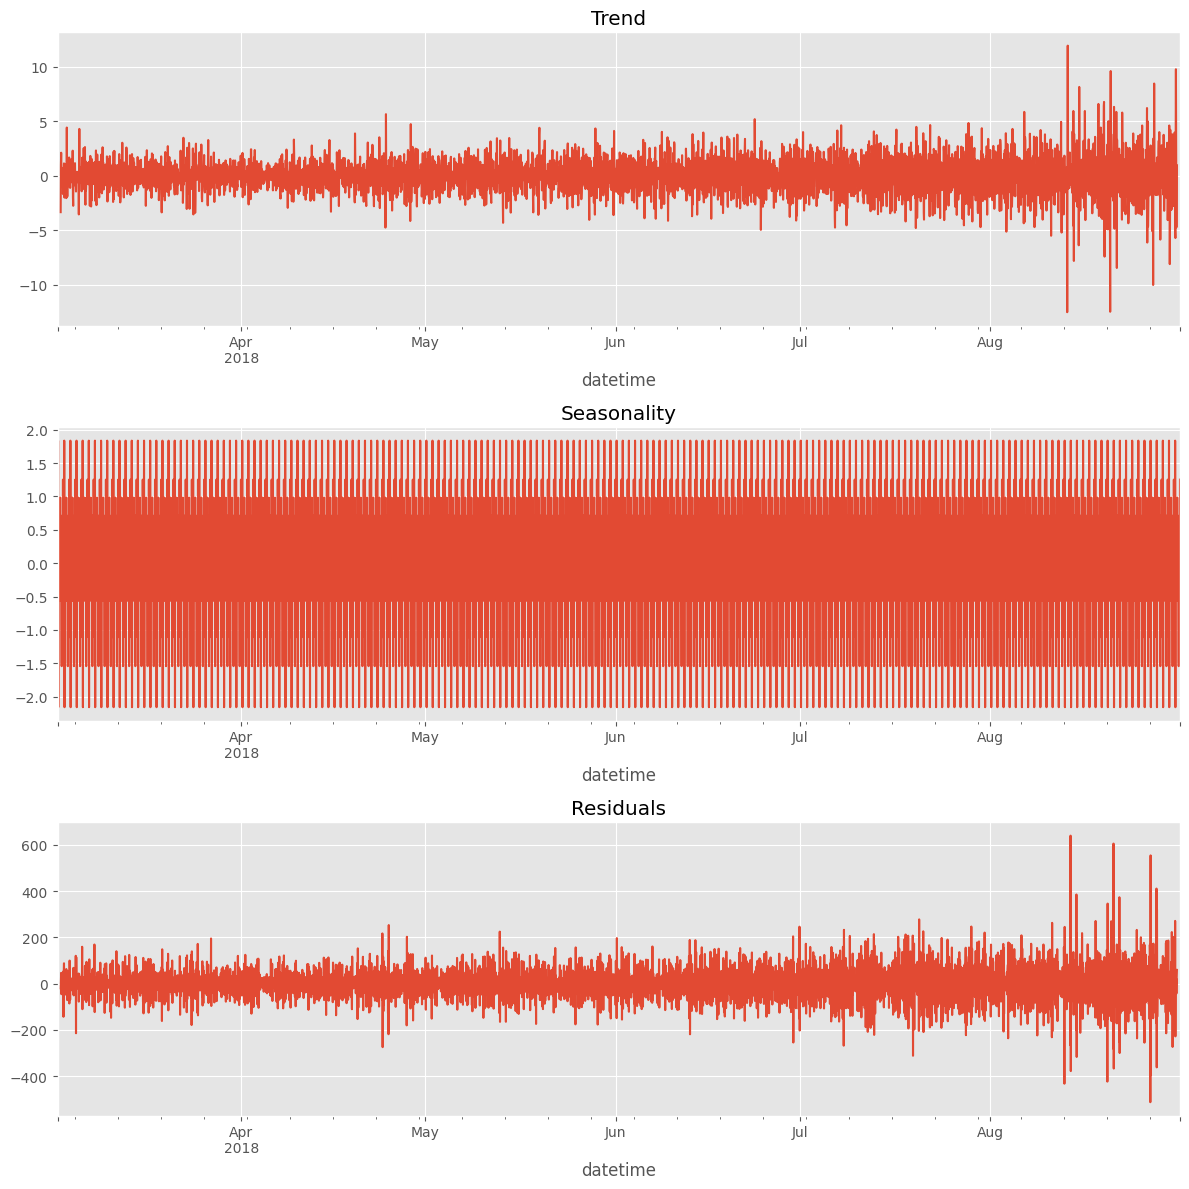

In [35]:
data_D1_d2 = data_D1_d1 - data_D1_d1.shift(1)
data_D1_d2.dropna(inplace=True)

plt.style.use('ggplot')
decomposed_data_D1_d2 = seasonal_decompose(data_D1_d2)
plt.figure(figsize=(12, 12))

plt.subplot(311)
decomposed_data_D1_d2.trend.plot(ax=plt.gca())
plt.title('Trend')

plt.subplot(312)
decomposed_data_D1_d2.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')

plt.subplot(313)
decomposed_data_D1_d2.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

In [36]:
# Проверим стационарность после применения повторного дифференцирования
test = sm.tsa.adfuller(data_D1_d2['num_orders'])
print('adf: ', test[0])
print('p-value: ', test[1])
print('Critical values: ', test[4])
if test[0]> test[4]['5%']:
    print('есть единичные корни, ряд не стационарен')
else:
    print('единичных корней нет, ряд стационарен')

adf:  -17.206929837282036
p-value:  6.405733716097136e-30
Critical values:  {'1%': -3.431851412562936, '5%': -2.8622034404898624, '10%': -2.5671231538691432}
единичных корней нет, ряд стационарен


> Разброс тренда изменился. Повторим дифференцирование.

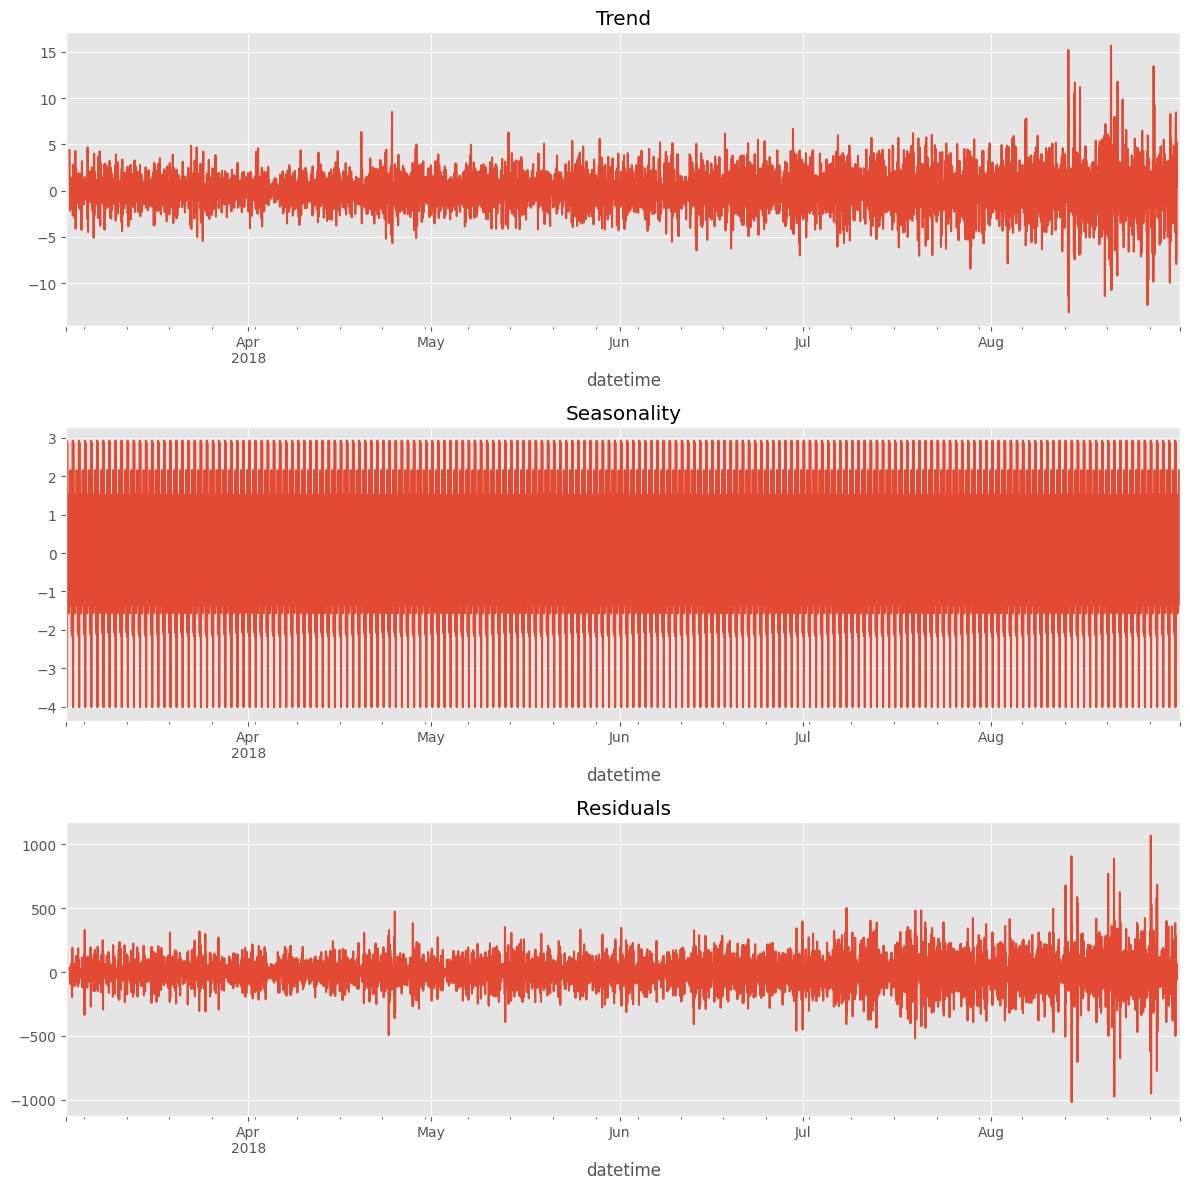

In [37]:
data_D1_d3 = data_D1_d2 - data_D1_d2.shift(1)
data_D1_d3.dropna(inplace=True)

plt.style.use('ggplot')
decomposed_data_D1_d3 = seasonal_decompose(data_D1_d3)
plt.figure(figsize=(12, 12))

plt.subplot(311)
decomposed_data_D1_d3.trend.plot(ax=plt.gca())
plt.title('Trend')

plt.subplot(312)
decomposed_data_D1_d3.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')

plt.subplot(313)
decomposed_data_D1_d3.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

In [38]:
# Проверим стационарность после применения повторного дифференцирования на предыдущем дне
test = sm.tsa.adfuller(data_D1_d3['num_orders'])
print('adf: ', test[0])
print('p-value: ', test[1])
print('Critical values: ', test[4])
if test[0]> test[4]['5%']:
    print('есть единичные корни, ряд не стационарен')
else:
    print('единичных корней нет, ряд стационарен')

adf:  -30.088784449024647
p-value:  0.0
Critical values:  {'1%': -3.4318510679201006, '5%': -2.8622032882383506, '10%': -2.5671230728180445}
единичных корней нет, ряд стационарен


> Разброс тренда ухудшился. Применим функцию логарифмирования к начальным данным и повторим шаги дифференцирования.

In [39]:
data['num_orders']

datetime
2018-03-01 00:00:00    124
2018-03-01 01:00:00     85
2018-03-01 02:00:00     71
2018-03-01 03:00:00     66
2018-03-01 04:00:00     43
                      ... 
2018-08-31 19:00:00    136
2018-08-31 20:00:00    154
2018-08-31 21:00:00    159
2018-08-31 22:00:00    223
2018-08-31 23:00:00    205
Freq: H, Name: num_orders, Length: 4416, dtype: int64

In [40]:
df_BC = data.copy()
df_BC['num_orders'] = pt.fit_transform(df_BC)
df_BC

num_orders
datetime                       
2018-03-01 00:00:00    0.926262
2018-03-01 01:00:00    0.147722
2018-03-01 02:00:00   -0.174203
2018-03-01 03:00:00   -0.296688
2018-03-01 04:00:00   -0.930597
...                         ...
2018-08-31 19:00:00    1.140345
2018-08-31 20:00:00    1.444579
2018-08-31 21:00:00    1.525906
2018-08-31 22:00:00    2.471952
2018-08-31 23:00:00    2.221349

[4416 rows x 1 columns]

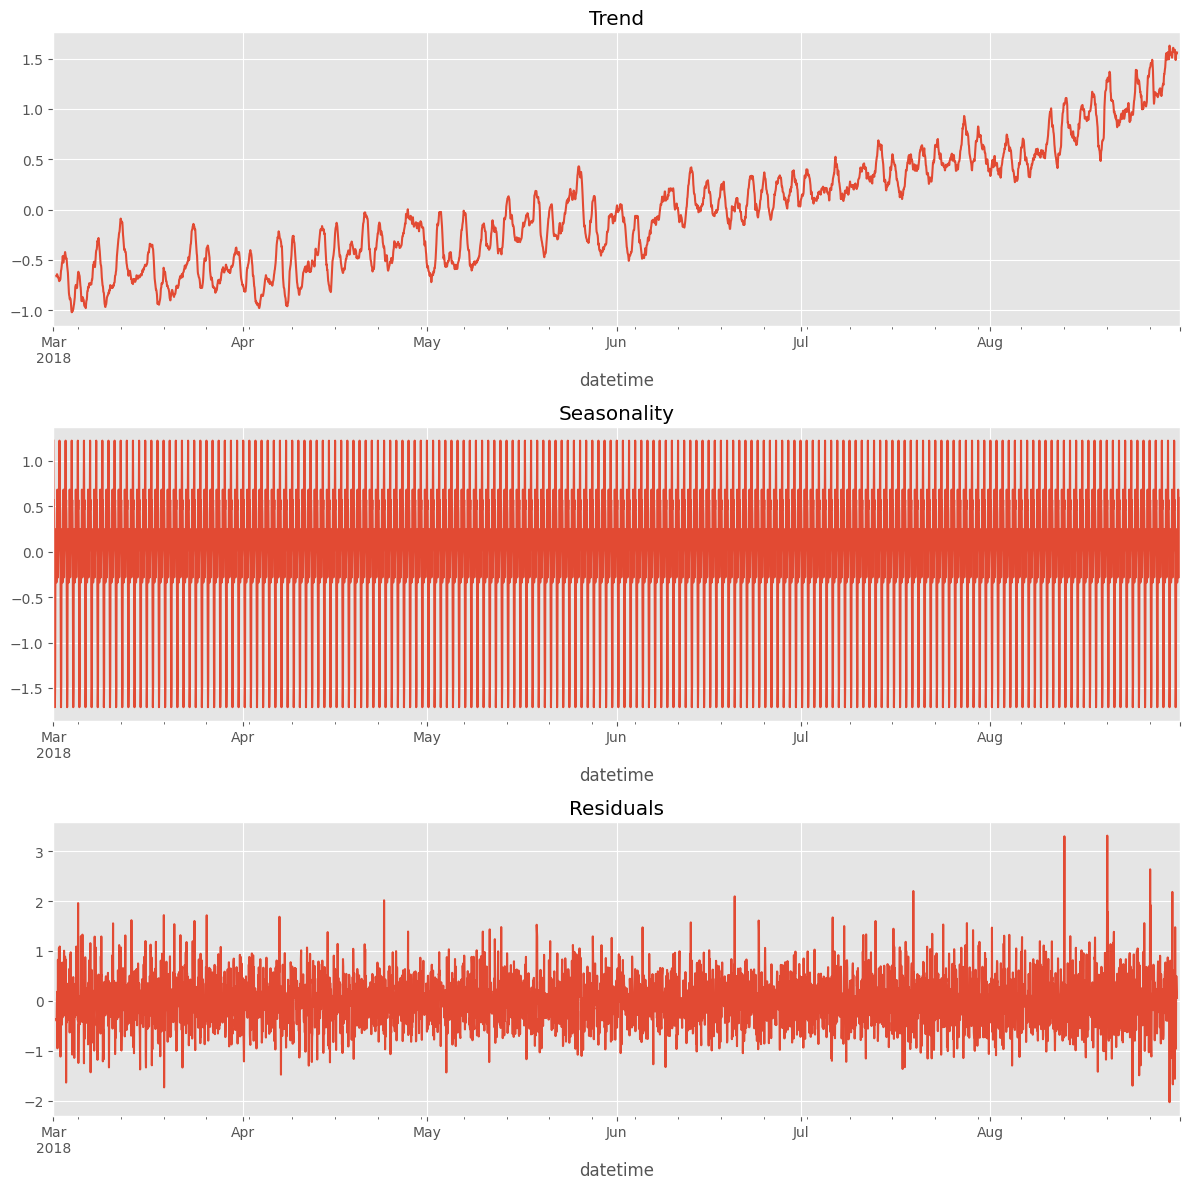

In [41]:
plt.style.use('ggplot')
decomposed_df_BC = seasonal_decompose(df_BC)
plt.figure(figsize=(12, 12))

plt.subplot(311)
decomposed_df_BC.trend.plot(ax=plt.gca())
plt.title('Trend')

plt.subplot(312)
decomposed_df_BC.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')

plt.subplot(313)
decomposed_df_BC.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

In [42]:
# Проверим стационарность после применения логорифмирования
test = sm.tsa.adfuller(df_BC)
print('adf: ', test[0])
print('p-value: ', test[1])
print('Critical values: ', test[4])
if test[0]> test[4]['5%']:
    print('есть единичные корни, ряд не стационарен')
else:
    print('единичных корней нет, ряд стационарен')

adf:  -3.327912008370789
p-value:  0.013675985293498328
Critical values:  {'1%': -3.431842162413052, '5%': -2.8621993540813637, '10%': -2.567120978470452}
единичных корней нет, ряд стационарен


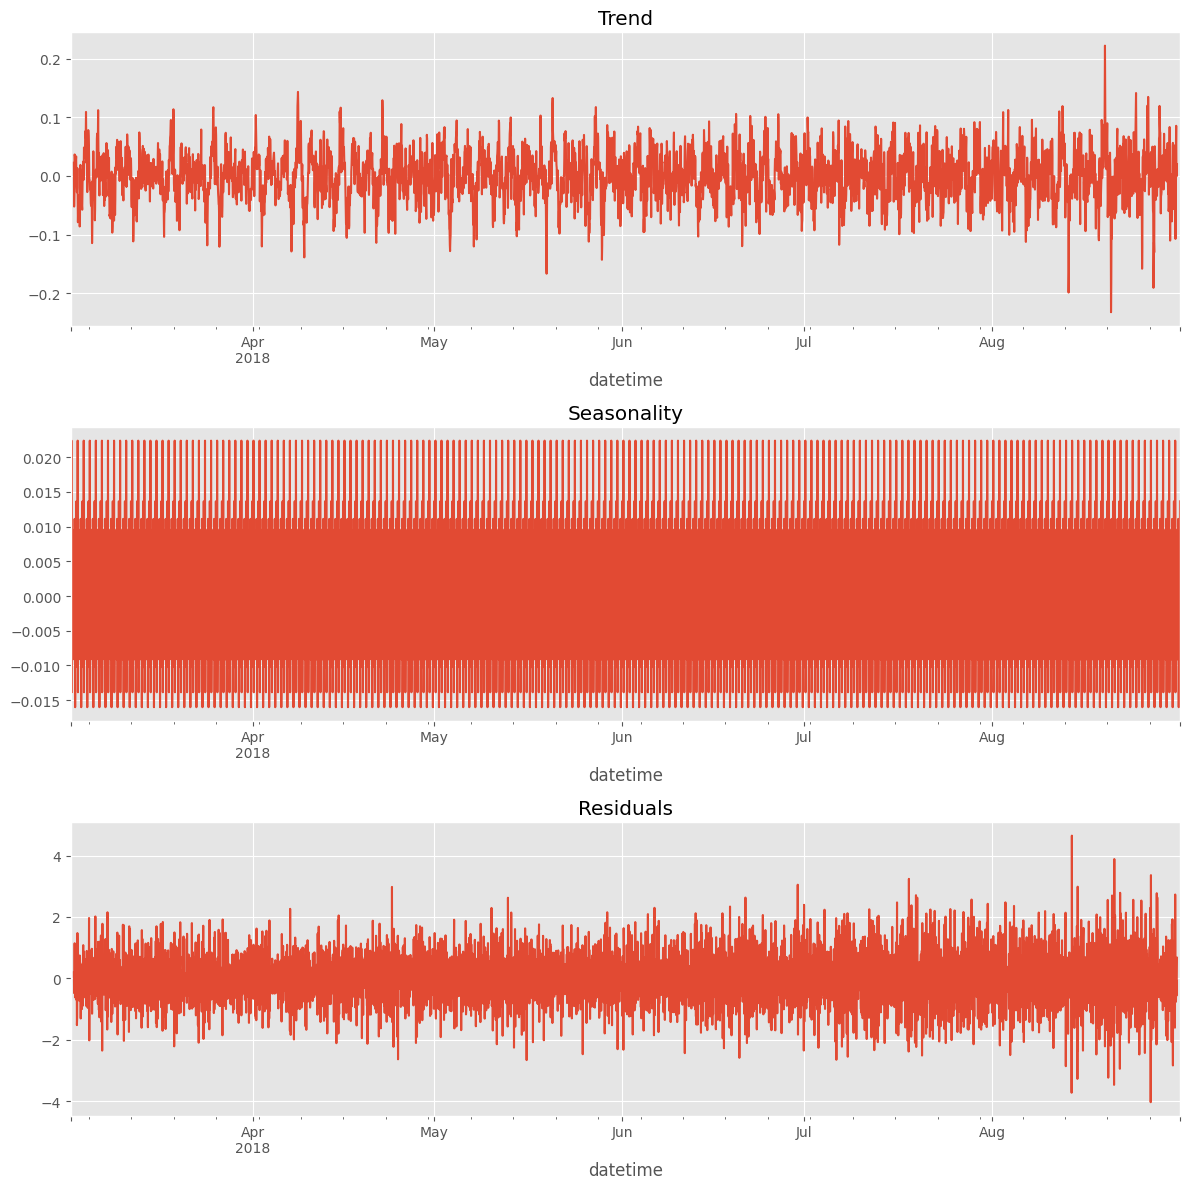

In [43]:
# Проведем все трансформации с прологарифмированным рядом
df_BC_D1 = df_BC - df_BC.shift(24)
df_BC_D1_d1 = df_BC_D1 - df_BC_D1.shift(1)
df_BC_D1_d1.dropna(inplace=True)

plt.style.use('ggplot')
decomposed_df_BC_D1_d1 = seasonal_decompose(df_BC_D1_d1)
plt.figure(figsize=(12, 12))

plt.subplot(311)
decomposed_df_BC_D1_d1.trend.plot(ax=plt.gca())
plt.title('Trend')

plt.subplot(312)
decomposed_df_BC_D1_d1.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')

plt.subplot(313)
decomposed_df_BC_D1_d1.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

In [44]:
# Проверим стационарность после применения трансформаций над логорифмированным рядом
test = sm.tsa.adfuller(df_BC_D1_d1)
print('adf: ', test[0])
print('p-value: ', test[1])
print('Critical values: ', test[4])
if test[0]> test[4]['5%']:
    print('есть единичные корни, ряд не стационарен')
else:
    print('единичных корней нет, ряд стационарен')

adf:  -23.125606282363865
p-value:  0.0
Critical values:  {'1%': -3.4318510679201006, '5%': -2.8622032882383506, '10%': -2.5671230728180445}
единичных корней нет, ряд стационарен


> В ходе работы над стационарным рядом тренд стал мало изменяться, значит можно считаться с критерием Дики-Фуллера.
>
> Мы нашли два параметра из 6 для SARIMA модели: **D=1, d=2.**
>
> Найдем остальные по результатам авто и частичной корреляции.

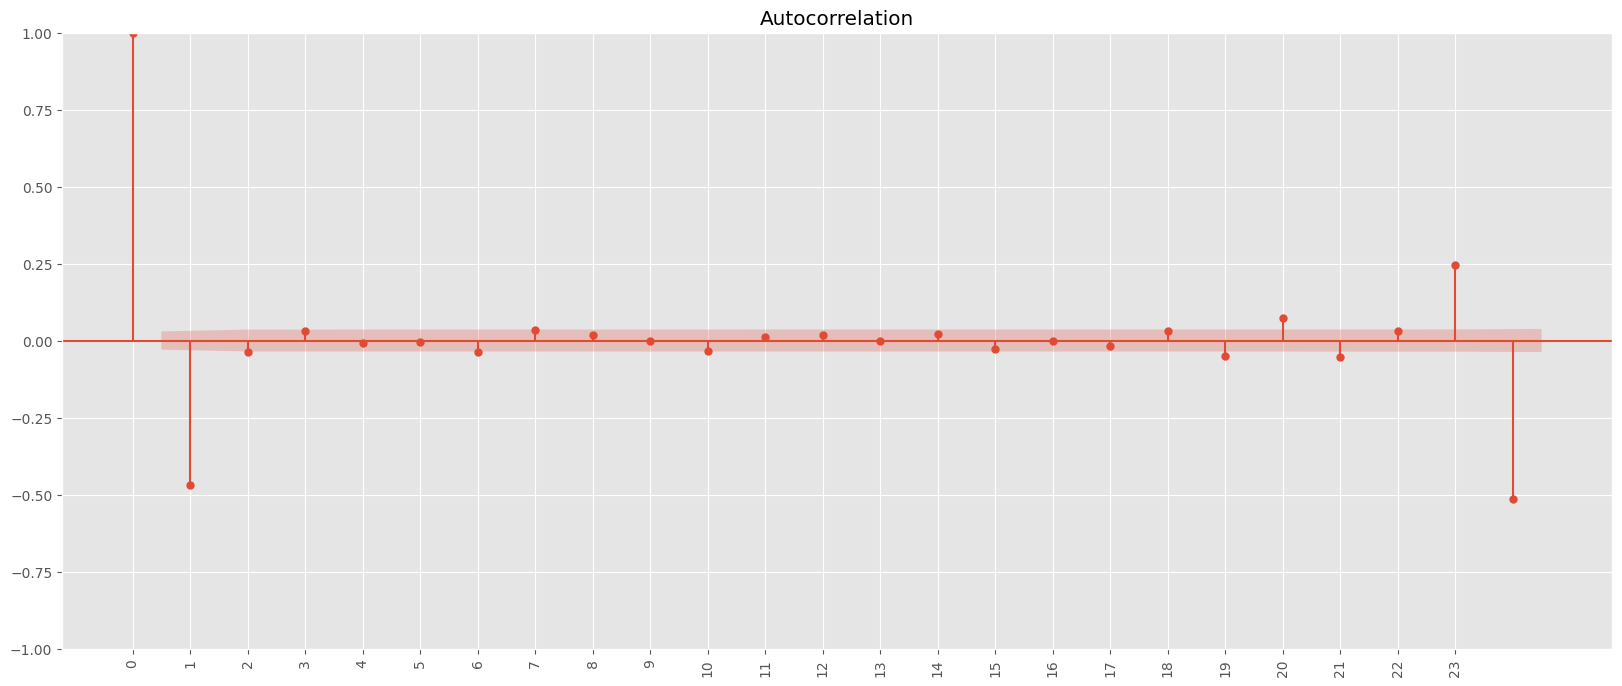

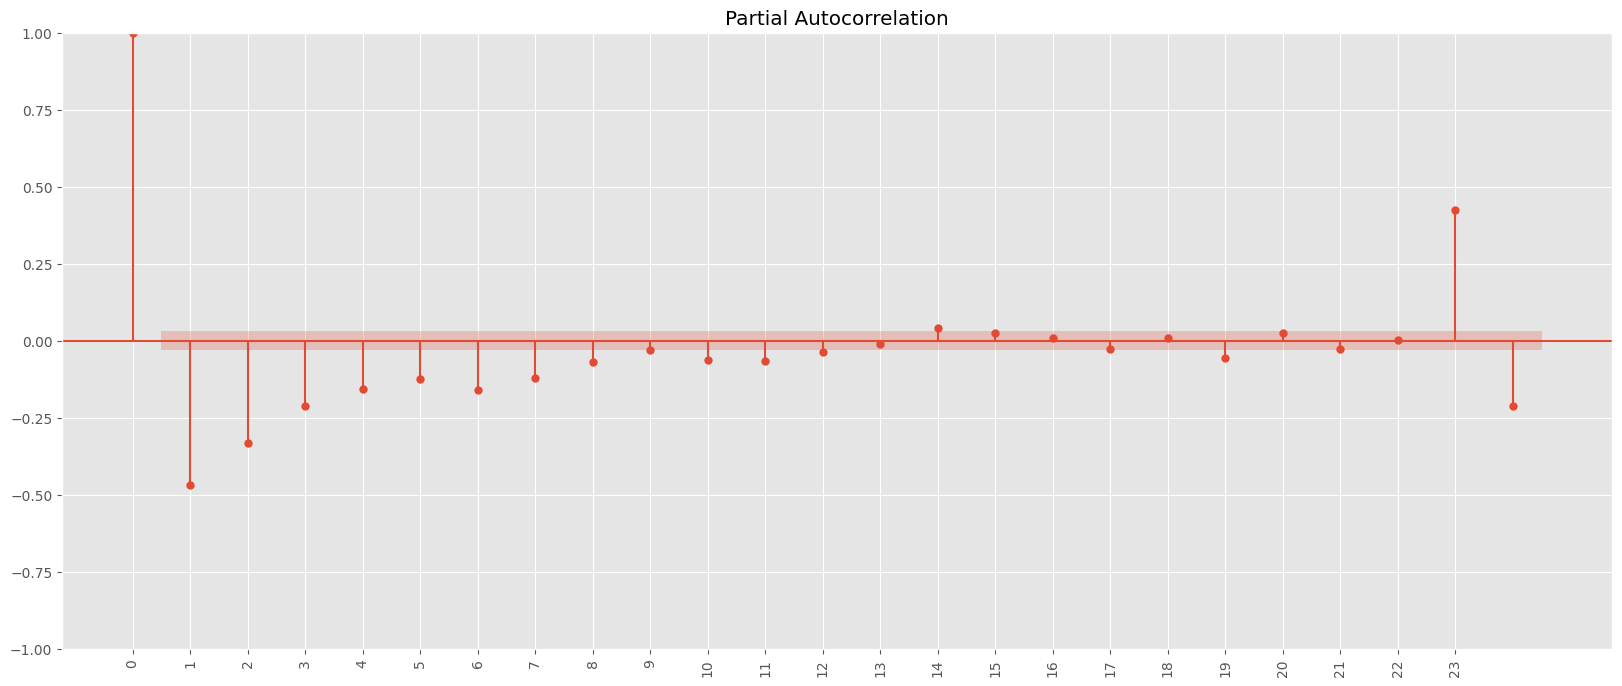

In [45]:
# Для определения p и q построим коррелограммы ACF и PACF
time_list = df_BC_D1_d1['num_orders']
lags = 24
plt.figure(figsize=(20,8))
plt.xticks(list(range(lags)),rotation=90)
ax = plt.subplot(111)
acf = plot_acf(time_list, lags=lags, ax=ax)
plt.show()
plt.figure(figsize=(20,8))
plt.xticks(list(range(lags)),rotation=90)
ax = plt.subplot(111)
pacf = plot_pacf(time_list, lags=lags, ax=ax)

> Из гарфика PACF видно, что порядок AR будет p=8, а по ACF видно, что порядок MA q = 2, т.к. 2 лаг — это последний лаг отличный от 0.
>
> **Параметр q=2 и параметр p=8.**
>
> Теперь перейдем к сезонным составляющим. Для их оценки надо смотреть на лаги кратные размеру сезонности, т.е., если для нашего примера, сезонность 24, то надо рассматривать лаги 24, 48, 72, ...

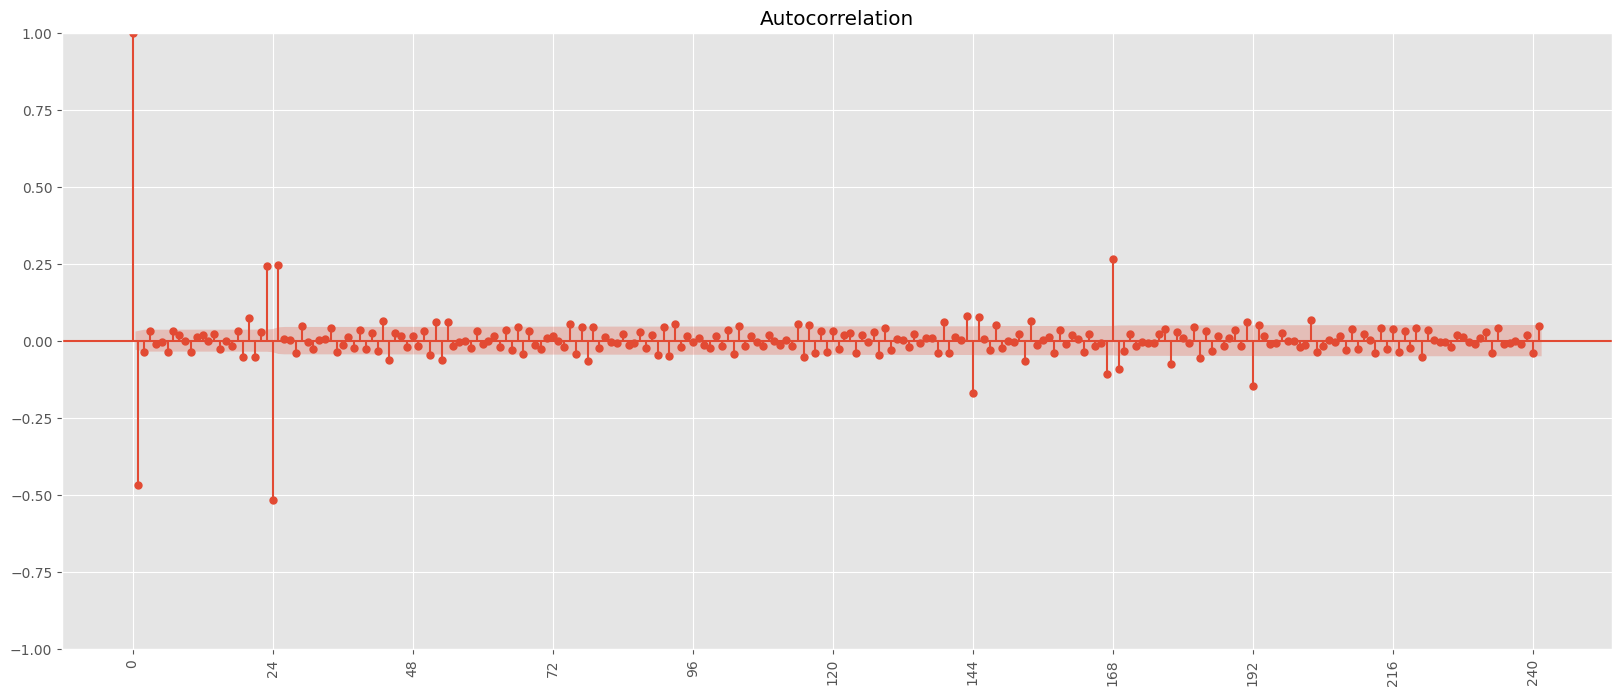

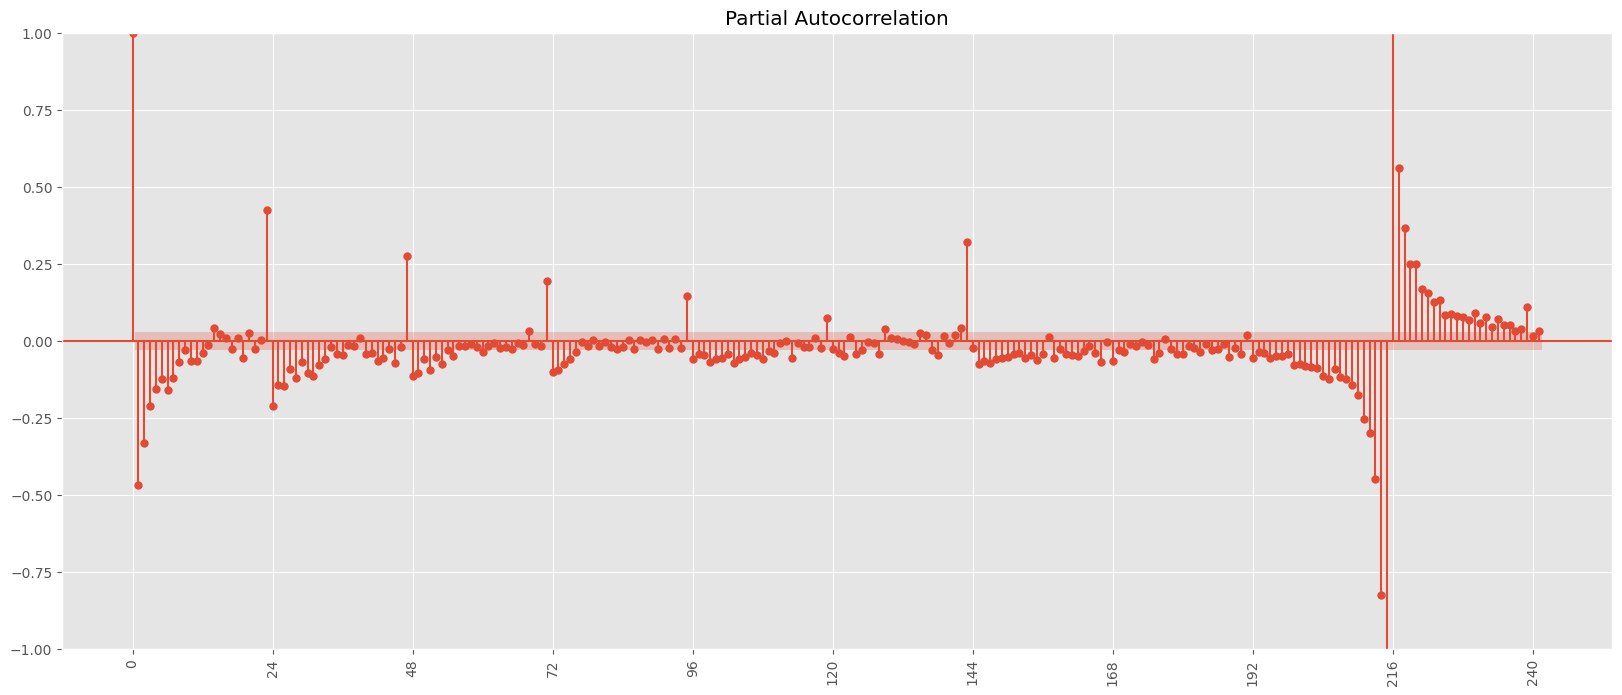

In [46]:
# Найдем сезонные параметры
lags = 241
plt.figure(figsize=(20,8))
plt.xticks(list(range(0,lags,24)),rotation=90)
ax = plt.subplot(111)
acf = plot_acf(time_list, lags=lags, ax=ax)
plt.show()
plt.figure(figsize=(20,8))
plt.xticks(list(range(0,lags,24)),rotation=90)
ax = plt.subplot(111)
pacf = plot_pacf(time_list, lags=lags, ax=ax)

> **Параметр Q=1 и параметр P=6.**

### Поиск лучшей модели SARIMA
В результате наших исследований мы получили модель:

$$
SARIMA(8,2,2)(6,1,1)_{24}
$$

Исходя из того, что всего сочетаний с текущим набором параметров будет 120 и высоких параметрах p и P, модель может обучаться практически бесконечно, было принято решение провести сочетания параметров не выше 2го порядка.

Расходящиеся модели будут пропускаться при долгой обработке.

Оценивающим критерием будет AIC.

In [47]:
d=1
D=1
s=24
best_model = ''
best_aic = float('inf')

params = [(0, 0, 0, 0),
          (1, 1, 1, 1),
          (2, 1, 1, 1),
          (1, 1, 2, 1)]

In [48]:
%%time

result = []
best_model = 0
best_aic = float('inf')
best_param = 0

for param in params:
    try:
        model = sarimax.SARIMAX(df_BC['num_orders'],
                       order=(param[0], d, param[1]),
                       seasonal_order=(param[2], D, param[3],s)).fit(disp=-1)
        aic = model.aic
        print([param, aic])
        result.append([param, aic])
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
    except:
        print('wrong params', param)
        continue

[(0, 0, 0, 0), 11489.363269301162]
[(1, 1, 1, 1), 6379.786038654185]
[(2, 1, 1, 1), 6375.705893571614]
[(1, 1, 2, 1), 6381.701821689235]
CPU times: user 2min 41s, sys: 1min 17s, total: 3min 59s
Wall time: 2min 40s


In [49]:
print(best_model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                         num_orders   No. Observations:                 4416
Model:             SARIMAX(2, 1, 1)x(1, 1, 1, 24)   Log Likelihood               -3181.853
Date:                            Tue, 08 Aug 2023   AIC                           6375.706
Time:                                    17:34:28   BIC                           6414.030
Sample:                                03-01-2018   HQIC                          6389.227
                                     - 08-31-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1440      0.014      9.969      0.000       0.116       0.172
ar.L2          0.0819      0.014   

adf:  -14.667830765118218
p-value:  3.302799947162297e-27
Critical values:  {'1%': -3.431842162413052, '5%': -2.8621993540813637, '10%': -2.567120978470452}
единичных корней нет, ряд стационарен


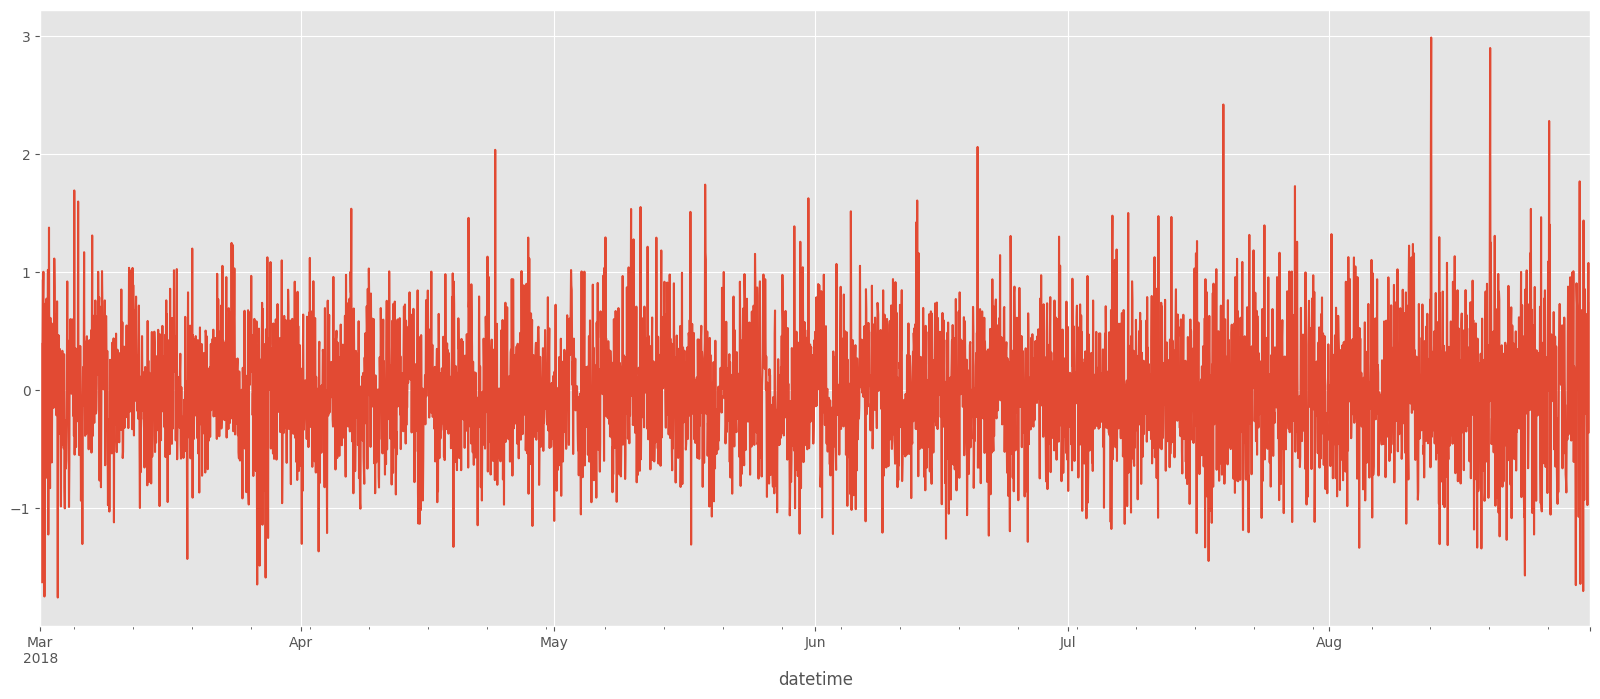

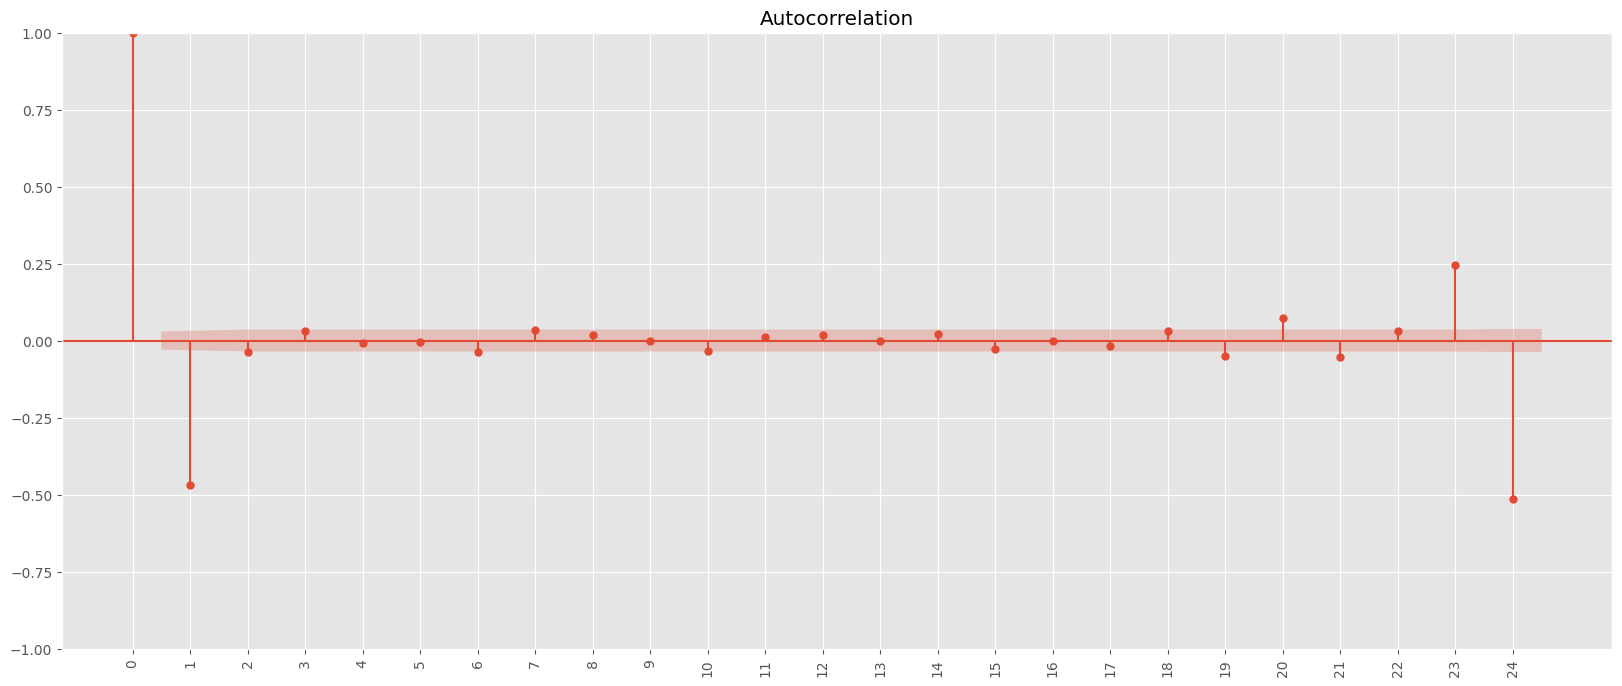

In [50]:
bm_resid = best_model.resid # остатки и автокореляция

plt.figure(figsize=(20,8))
plt.xticks(list(range(0,lags,24)),rotation=90)
ax = plt.subplot(111)
bm_resid.plot(ax=ax)

lags = 24
plt.figure(figsize=(20,8))
plt.xticks(list(range(0,lags+1)),rotation=90)
ax = plt.subplot(111)
acf = plot_acf(time_list, lags=lags, ax=ax)

test = sm.tsa.adfuller(bm_resid)
print('adf: ', test[0])
print('p-value: ', test[1])
print('Critical values: ', test[4])
if test[0]> test[4]['5%']:
    print('есть единичные корни, ряд не стационарен')
else:
    print('единичных корней нет, ряд стационарен')

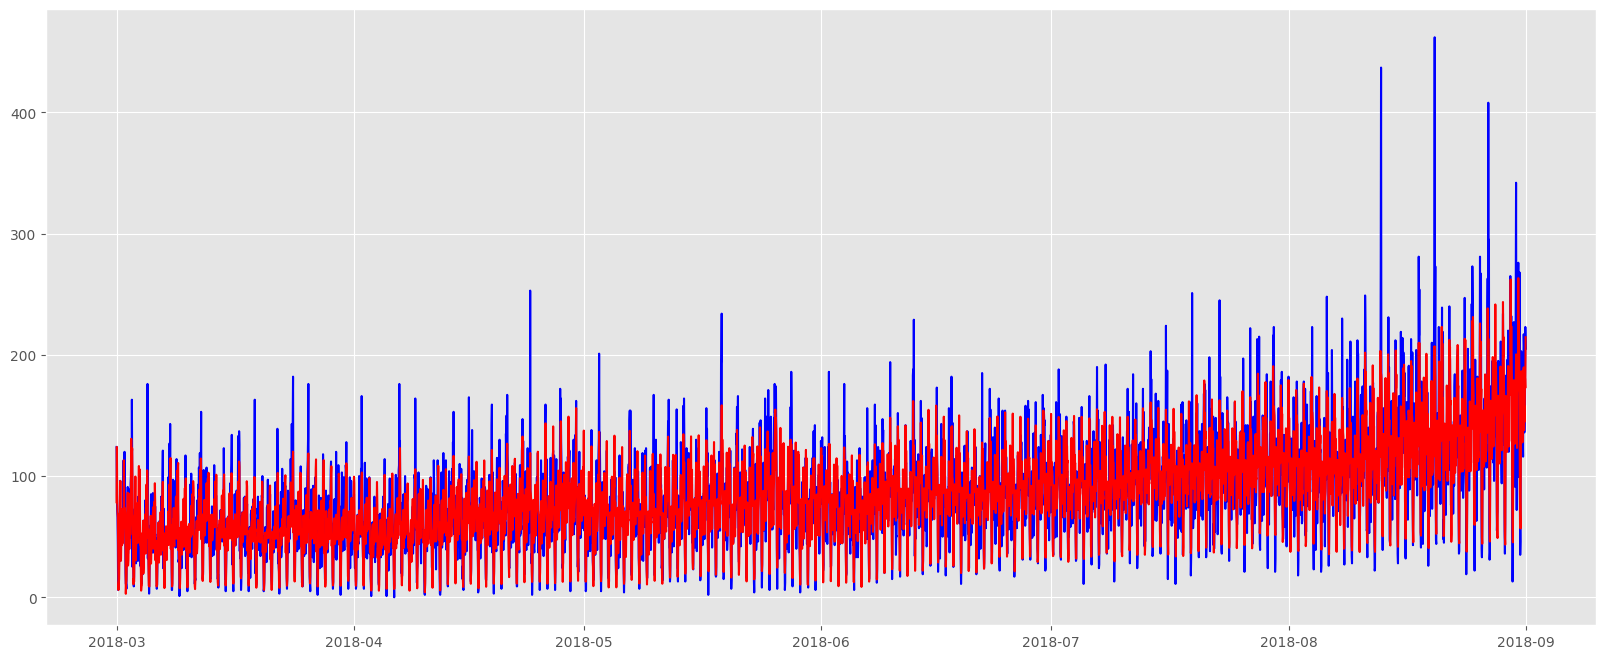

In [51]:
best_model_data = df_BC.copy()
best_model_data['num_orders'] = best_model.fittedvalues

plt.figure(figsize=(20,8))
plt.plot(data.index,
         data['num_orders'],
         'b-',
         data.index,
         pt.inverse_transform(best_model_data),
         'r-');

> Как видно из графика данные модели SARIMA напоминают оригинальные данные. Проведем кроссвалидацию данной модели.

### Обучение модели

In [52]:
train_SARIMA, test_SARIMA = train_test_split(df, shuffle=False, test_size=0.1, random_state=random)
train_SARIMA_BC = pt.fit_transform(train_SARIMA)

In [53]:
def cv_time_series_rmse_SARIMA(data, target_column, n_splits, max_train_size):
    tscv = TimeSeriesSplit(n_splits = n_splits, max_train_size = cv_train_test_split)
    RMSE = 0.0
    for train_index, test_index in tscv.split(data):
        train = data.iloc[train_index]
        test = data.iloc[test_index]
        train_BC = pt.fit_transform(train)
        SARIMA_model = sarimax.SARIMAX(train_BC,
                                       order=best_order,
                                      seasonal_order=best_seasonal_order).fit(disp=-1)
        predict_date_start = min(test_index)
        predict_date_end = max(test_index)
        predicted = test.copy()
        predicted[target_column] = SARIMA_model.predict(start=predict_date_start,
                                                        end=predict_date_end)
        predicted = pt.inverse_transform(predicted)
        RMSE += mean_squared_error(test[target_column], predicted) ** 0.5
    return RMSE / n_splits

In [54]:
%%time
# Зададим найденные параметры
best_order=[2, 1, 1]
best_seasonal_order=[1, 1, 1, 24]

# Инициализируем модель
rmse_on_train_SARIMA = cv_time_series_rmse_SARIMA(data=train_SARIMA,
                                            target_column='num_orders',
                                            n_splits=cv_splits,
                                            max_train_size=cv_train_test_split)
print('RMSE на тренировочной выборке:', rmse_on_train_SARIMA)

RMSE на тренировочной выборке: 34.86605432631894
CPU times: user 1min 8s, sys: 42.7 s, total: 1min 51s
Wall time: 1min 13s


### Тестирование модели

In [55]:
# Инициализируем модель
SARIMA_model = sarimax.SARIMAX(train_SARIMA_BC,
                               order=best_order,
                               seasonal_order=best_seasonal_order).fit(disp=-1)

# Высчитаем метрики
predict_date_start = train_SARIMA.shape[0]
predict_date_end = predict_date_start + test_SARIMA.shape[0] - 1
predicted = test_SARIMA.copy()
predicted['num_orders'] = SARIMA_model.predict(start=predict_date_start,
                                               end=predict_date_end)
predicted = pt.inverse_transform(predicted)
rmse_on_test_SARIMA = mean_squared_error(test_SARIMA['num_orders'], predicted) ** 0.5
print('RMSE на тестовой выборке:', rmse_on_test_SARIMA)


RMSE на тестовой выборке: 38.919716859982444


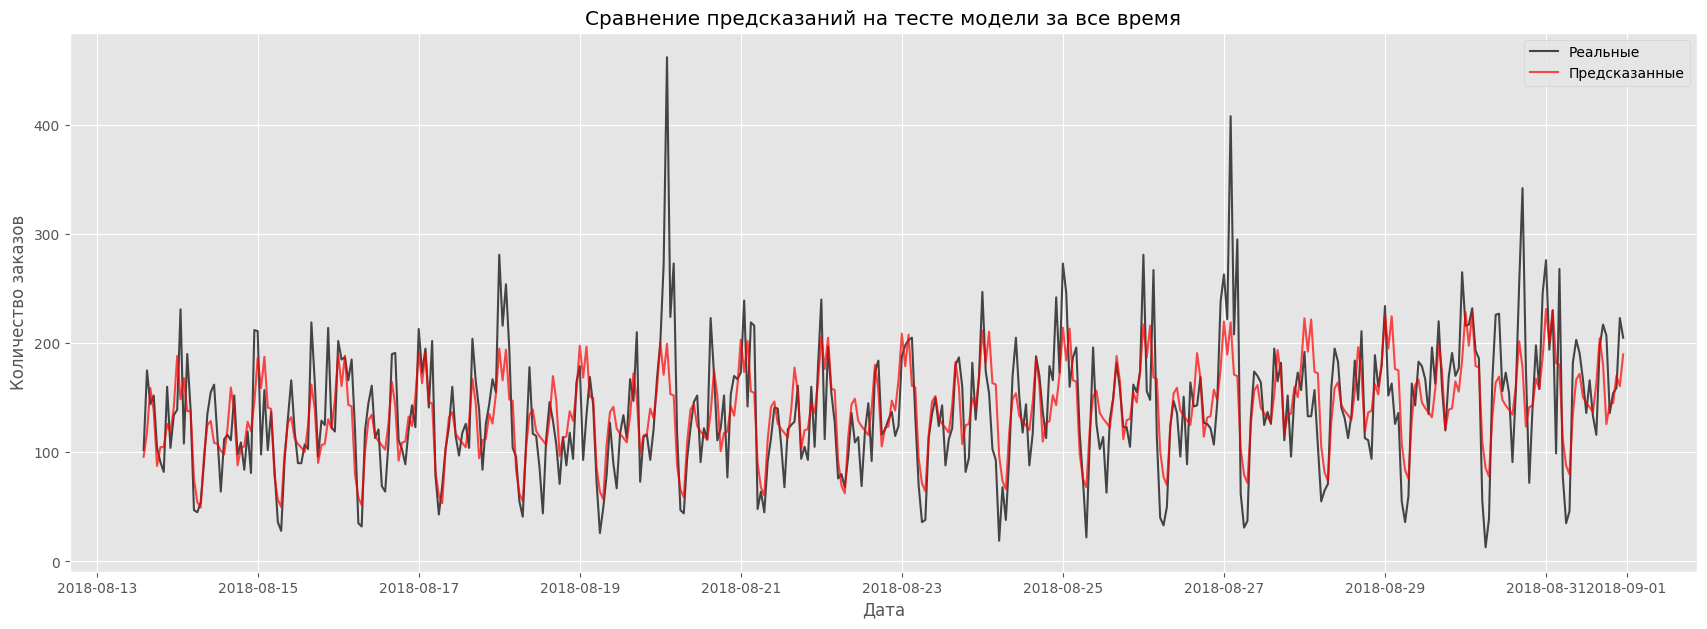

In [58]:
# Рассмотрим графики сравнения предсказаний и реальных значений
plt.figure(figsize=(21,7))
plt.plot(test_SARIMA.index,
         test_SARIMA['num_orders'],
         color='black',
         alpha=0.7)
plt.plot(test_SARIMA.index,
         predicted,
         color='red',
         alpha=0.7)
plt.title('Сравнение предсказаний на тесте модели за все время')
plt.ylabel('Количество заказов')
plt.xlabel('Дата')
plt.legend(['Реальные', 'Предсказанные'])
plt.show()

# Вывод
1. Во время проекта были изучены способы предсказания веременных рядов за счет регрессоров и аналитической модели SARIMA.

2. При обучении регрессивных моделей лучше всего себя показала модель CatBoostRegressor с параметрами 'learning_rate': 0.1, 'max_depth': 3. Однако при тестировании обученной модели RMSE показатель достиг значения 50,4 (а согласно техническому заданию данный показатель не должен превышать 48).

3. Лучше всело предсказала ряд модель SARIMA. Это единственная модель, которая имеет достаточно низкое RMSE = 38,9. Это означает, что модель в среднем ошибаетс на 38-39 заказа такси в час.

4. В целом данные имеют очень много шумов, которые влияют на все стандартные регрессоры.